In [8]:
# Import libs

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import skew

from keras.models import Model
from keras.utils import plot_model
from keras.optimizers import Nadam
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.layers import Dropout, Dense, Flatten, Input, Embedding, Dot, BatchNormalization, Multiply, concatenate

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error, r2_score, confusion_matrix

from skopt import BayesSearchCV
from skopt.plots import plot_evaluations, plot_objective, plot_convergence

from surprise import Dataset, Reader, SVD
from surprise.model_selection import train_test_split as __train_test_split__

In [94]:
# Get data frame of movies
df_movies = pd.read_csv(open("movies.csv", 'rb'))
df_movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [95]:
# Get data frame about users ratings
df_ratings = pd.read_csv(open("ratings.csv", 'rb'))
df_ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


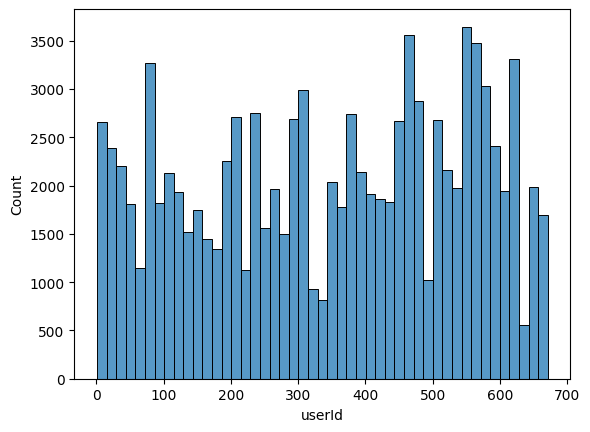

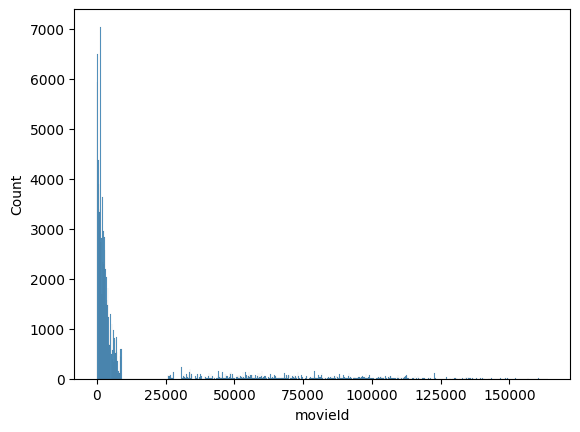

In [96]:
# Show data distribution
sns.histplot(df_ratings['userId'])
plt.show()

sns.histplot(df_ratings['movieId'])
plt.show()

In [97]:
# We need to schange indexes cause some of them are messing
users = df_ratings.userId.unique()
movies = df_movies.movieId.unique()

print(users.shape)
print(movies.shape)

(671,)
(9125,)


In [98]:
# Get new indexes
userid2idx = {o: i for i, o in enumerate(users)}
movieid2idx = {o: i for i, o in enumerate(movies)}
df = df_ratings.copy(deep = True)
df['userId'] = df['userId'].apply(lambda x: userid2idx[x])
df['movieId'] = df['movieId'].apply(lambda x: movieid2idx[x])
df.head()

,userId,movieId,rating,timestamp
0,0,30,2.5,1260759144
1,0,833,3.0,1260759179
2,0,859,3.0,1260759182
3,0,906,2.0,1260759185
4,0,931,4.0,1260759205


In [99]:
# Split data
train, test = train_test_split(df, train_size = 0.8, random_state = 1212)

In [ ]:
train.head()

,userId,movieId,rating,timestamp
66042,467,225,3.0,1296195784
73993,515,2082,4.0,844688797
17199,110,1026,4.0,1097431509
2985,16,2018,4.0,1127471083
51005,377,1433,0.5,1443625747


In [ ]:
# Simple Embdending model
user_input = Input(shape = (1,), dtype = 'int64')
user_embedding = Embedding(users.shape[0], 50)(user_input)
user_vec = Flatten(name = 'FlattenUsers')(user_embedding)
user_vec = Dense(32, activation = 'elu')(user_vec)

movie_input = Input(shape = (1,), dtype = 'int64')
movie_embedding = Embedding(movies.shape[0], 50)(movie_input)
movie_vec = Flatten(name = 'FlattenMovies')(movie_embedding)
movie_vec = Dense(32, activation = 'elu')(movie_vec)

sim = Dot(axes = 1)([user_vec, movie_vec])
model = Model([user_input, movie_input], sim)
model.compile(optimizer = Nadam(learning_rate = 0.001), loss = 'mse', metrics = ['mae'])

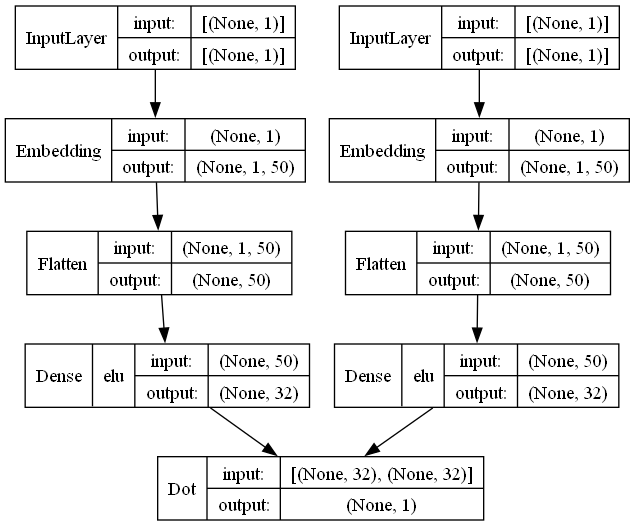

In [ ]:
plot_model(model, show_shapes = True, show_layer_names = False, show_layer_activations = True)

In [16]:
# Define callbacks
earlyStopping = EarlyStopping(monitor = 'val_loss', patience = 5, verbose = True)
reduceLR = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1, patience = 3, verbose = True)

In [17]:
# Define evaluation function
def evaluate_model(true_values, predicted_values, history = None):
    print(f"MSE: {mean_squared_error(true_values, predicted_values)}")
    print(f"RMSE: {mean_squared_error(true_values, predicted_values) ** 0.5}")
    print(f"MAE: {mean_absolute_error(true_values, predicted_values)}")
    print(f"MSlogE: {mean_squared_log_error(true_values, np.maximum(predicted_values, 0))}")
    print(f"R^2: {r2_score(true_values, predicted_values)}")

    plt.plot(np.arange(0, 6, 1), np.arange(0, 6, 1), c = 'r')
    plt.scatter(true_values, predicted_values, c = abs(true_values - predicted_values), cmap = 'viridis')
    plt.show()

    if history is not None:
        plt.plot(history.history['loss'], c = 'deepskyblue')
        plt.plot(history.history['val_loss'], c = 'darkred')
        plt.legend(['Train loss', 'Test loss'])
        plt.show()

In [ ]:
history = model.fit([train['userId'], train['movieId']], train['rating'],
                            validation_data = ([test['userId'], test['movieId']], test['rating']),
                            batch_size = 64, epochs = 50, callbacks = [earlyStopping, reduceLR])

Epoch 1/50
1251/1251 [==============================] - 21s 14ms/step - loss: 1.8205 - mae: 0.9650 - val_loss: 0.8457 - val_mae: 0.7156 - lr: 0.0010
Epoch 2/50
1251/1251 [==============================] - 16s 12ms/step - loss: 0.7743 - mae: 0.6808 - val_loss: 0.8178 - val_mae: 0.6988 - lr: 0.0010
Epoch 3/50
1251/1251 [==============================] - 15s 12ms/step - loss: 0.7330 - mae: 0.6586 - val_loss: 0.8089 - val_mae: 0.6873 - lr: 0.0010
Epoch 4/50
1251/1251 [==============================] - 16s 13ms/step - loss: 0.6953 - mae: 0.6382 - val_loss: 0.7944 - val_mae: 0.6890 - lr: 0.0010
Epoch 5/50
1251/1251 [==============================] - 18s 14ms/step - loss: 0.6654 - mae: 0.6211 - val_loss: 0.7945 - val_mae: 0.6771 - lr: 0.0010
Epoch 6/50
1251/1251 [==============================] - 16s 13ms/step - loss: 0.6422 - mae: 0.6076 - val_loss: 0.8013 - val_mae: 0.6822 - lr: 0.0010
Epoch 7/50
1251/1251 [==============================] - ETA: 0s - loss: 0.6224 - mae: 0.5966
Epoch 7: Redu

626/626 [==============================] - 1s 2ms/step
MSE: 0.8119721202145926
RMSE: 0.9010949562696445
MAE: 0.6858724109468255
MSlogE: 0.057920834746239415
R^2: 0.27684998498573155


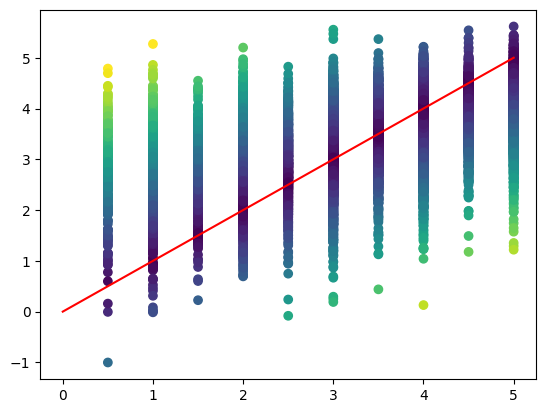

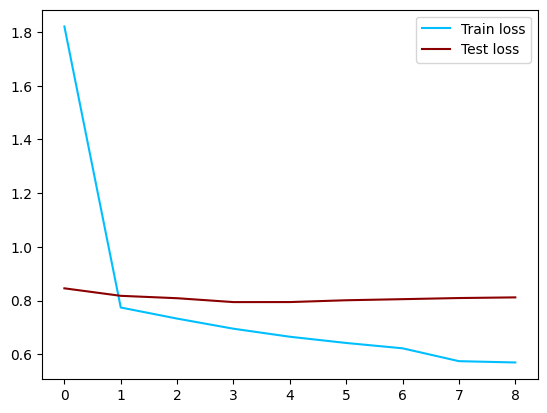

In [ ]:
predictions = model.predict([test['userId'], test['movieId']])
evaluate_model(test['rating'], predictions[:, 0], history)

In [ ]:
# Redefin it nit to spam in console
earlyStopping = EarlyStopping(monitor = 'val_loss', patience = 5, verbose = False)
reduceLR = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1, patience = 3, verbose = False)

In [18]:
# Define function to tune hyperparametrs
class Filmsmodel:
    def __init__(self, n_output_neurons = 32, n_layers_after_embending = 2,
                 n_neurons_after_embending = 32, n_output_layers = 2,
                 n_neurons_after_output = 32, drop_out_prob = 0.5, batchNormalization = True):
        self.n_output_neurons = n_output_neurons
        self.n_layers_after_embending = n_layers_after_embending
        self.n_neurons_after_embending = n_neurons_after_embending
        self.n_output_layers = n_output_layers
        self.n_neurons_after_output = n_neurons_after_output
        self.drop_out_prob = drop_out_prob
        self.batchNormalization = batchNormalization


    def get_params(self, deep = True):
        return {
            'n_output_neurons': self.n_output_neurons,
            'n_layers_after_embending': self.n_layers_after_embending,
            'n_neurons_after_embending': self.n_neurons_after_embending,
            'n_output_layers': self.n_output_layers,
            'n_neurons_after_output': self.n_neurons_after_output,
            'drop_out_prob' : self.drop_out_prob,
            'batchNormalization' : self.batchNormalization
        }


    def set_params(self, **params):
        for param, value in params.items():
            setattr(self, param, value)
        return self


    def create_model(self):
        user_input = Input(shape = (1, ), dtype = 'int64')
        user_embedding = Embedding(users.shape[0] + 1, self.n_output_neurons)(user_input)
        user_vec = Flatten()(user_embedding)
        for i in range(self.n_layers_after_embending):
            user_vec = Dense(self.n_neurons_after_embending // 2 ** (i), activation = 'elu')(user_vec)
            if self.batchNormalization:
                user_vec = BatchNormalization()(user_vec)
            if self.drop_out_prob:
                user_vec = Dropout(self.drop_out_prob)(user_vec)

        movie_input = Input(shape = (1,), dtype = 'int64')
        movie_embedding = Embedding(movies.shape[0], self.n_output_neurons)(movie_input)
        movie_vec = Flatten()(movie_embedding)
        for i in range(self.n_layers_after_embending):
            movie_vec = Dense(self.n_neurons_after_embending // 2 ** (i), activation = 'elu')(movie_vec)
            if self.batchNormalization:
                movie_vec = BatchNormalization()(movie_vec)
            if self.drop_out_prob:
                movie_vec = Dropout(self.drop_out_prob)(movie_vec)

        dot = Dot(axes = 1)([user_vec, movie_vec])
        for i in range(self.n_output_layers):
            dot = Dense(self.n_neurons_after_output // 2 ** (i), activation = 'elu')(dot)
            if self.batchNormalization:
                dot = BatchNormalization()(dot)
            if self.drop_out_prob:
                dot = Dropout(self.drop_out_prob)(dot)

        if (self.n_output_layers):
            dot = Dense(1, activation = 'relu')(dot)

        self.model = Model([user_input, movie_input], dot)
        self.model.compile(optimizer = Nadam(learning_rate = 0.001), loss = 'mse', metrics = ['mae'])


    def fit(self, X, y):
        print(self.get_params())
        self.create_model()
        self.history = self.model.fit([train['userId'], train['movieId']],
                  train['rating'],
                  epochs = 50,
                  batch_size = 64,
                  validation_data = [[test['userId'], test['movieId']], test['rating']],
                  callbacks = [earlyStopping, reduceLR],
                  verbose = True)

        predicted = self.model.predict([train['userId'], train['movieId']], verbose = False)
        return r2_score(train['rating'], predicted[:, 0])


    def score(self, X, y):
        predicted = self.model.predict([test['userId'], test['movieId']], verbose = False)
        print("r^2: ", r2_score(test['rating'], predicted[:, 0]))
        return r2_score(test['rating'], predicted[:, 0])

In [ ]:
# Define dict with parametrs rage
params = {
            'n_output_neurons': np.arange(8, 128, 8),
            'n_layers_after_embending': np.arange(0, 4, 1),
            'n_neurons_after_embending': np.arange(8, 128, 8),
            'n_output_layers': np.arange(0, 4, 1),
            'n_neurons_after_output': np.arange(8, 128, 8),
            'drop_out_prob' : [0, 0.25, 0.5, 0.75],
            'batchNormalization' : [False, True]
        }

# And find best parametrs using Bayes search
opt = BayesSearchCV(
    Filmsmodel(),
    params,
    cv = 2,
    n_iter = 30,
    random_state = 1213
)

opt.fit(np.zeros((10, )), np.zeros(10))

{'n_output_neurons': 48, 'n_layers_after_embending': 1, 'n_neurons_after_embending': 112, 'n_output_layers': 0, 'n_neurons_after_output': 120, 'drop_out_prob': 0.75, 'batchNormalization': True}
r^2:  0.1019840494012535
{'n_output_neurons': 48, 'n_layers_after_embending': 1, 'n_neurons_after_embending': 112, 'n_output_layers': 0, 'n_neurons_after_output': 120, 'drop_out_prob': 0.75, 'batchNormalization': True}
r^2:  0.11043034194245849
{'n_output_neurons': 64, 'n_layers_after_embending': 3, 'n_neurons_after_embending': 32, 'n_output_layers': 2, 'n_neurons_after_output': 80, 'drop_out_prob': 0.25, 'batchNormalization': True}
r^2:  0.2256188159380984
{'n_output_neurons': 64, 'n_layers_after_embending': 3, 'n_neurons_after_embending': 32, 'n_output_layers': 2, 'n_neurons_after_output': 80, 'drop_out_prob': 0.25, 'batchNormalization': True}
r^2:  0.2253528734146686
{'n_output_neurons': 16, 'n_layers_after_embending': 2, 'n_neurons_after_embending': 80, 'n_output_layers': 2, 'n_neurons_after

BayesSearchCV(cv=2,
              estimator=<__main__.Filmsmodel object at 0x000002116F5B1810>,
              n_iter=30, random_state=1213,
              search_spaces={'batchNormalization': [False, True],
                             'drop_out_prob': [0, 0.25, 0.5, 0.75],
                             'n_layers_after_embending': array([0, 1, 2, 3]),
                             'n_neurons_after_embending': array([  8,  16,  24,  32,  40,  48,  56,  64,  72,  80,  88,  96, 104,
       112, 120]),
                             'n_neurons_after_output': array([  8,  16,  24,  32,  40,  48,  56,  64,  72,  80,  88,  96, 104,
       112, 120]),
                             'n_output_layers': array([0, 1, 2, 3]),
                             'n_output_neurons': array([  8,  16,  24,  32,  40,  48,  56,  64,  72,  80,  88,  96, 104,
       112, 120])})

In [ ]:
# Show best parametrs
cv_results = opt.cv_results_
for i in range(len(cv_results['params'])):
    print(f"Iteration {i + 1} - Parameters: {cv_results['params'][i]}, Mean Test Score: {cv_results['mean_test_score'][i]}\n")

print("\nBest parameters found: ", opt.best_params_)

Iteration 1 - Parameters: OrderedDict([('batchNormalization', True), ('drop_out_prob', 0.75), ('n_layers_after_embending', 1), ('n_neurons_after_embending', 112), ('n_neurons_after_output', 120), ('n_output_layers', 0), ('n_output_neurons', 48)]), Mean Test Score: 0.10620719567185599

Iteration 2 - Parameters: OrderedDict([('batchNormalization', True), ('drop_out_prob', 0.25), ('n_layers_after_embending', 3), ('n_neurons_after_embending', 32), ('n_neurons_after_output', 80), ('n_output_layers', 2), ('n_output_neurons', 64)]), Mean Test Score: 0.2254858446763835

Iteration 3 - Parameters: OrderedDict([('batchNormalization', False), ('drop_out_prob', 0.75), ('n_layers_after_embending', 2), ('n_neurons_after_embending', 80), ('n_neurons_after_output', 80), ('n_output_layers', 2), ('n_output_neurons', 16)]), Mean Test Score: 0.22936303006837888

Iteration 4 - Parameters: OrderedDict([('batchNormalization', True), ('drop_out_prob', 0), ('n_layers_after_embending', 3), ('n_neurons_after_embe

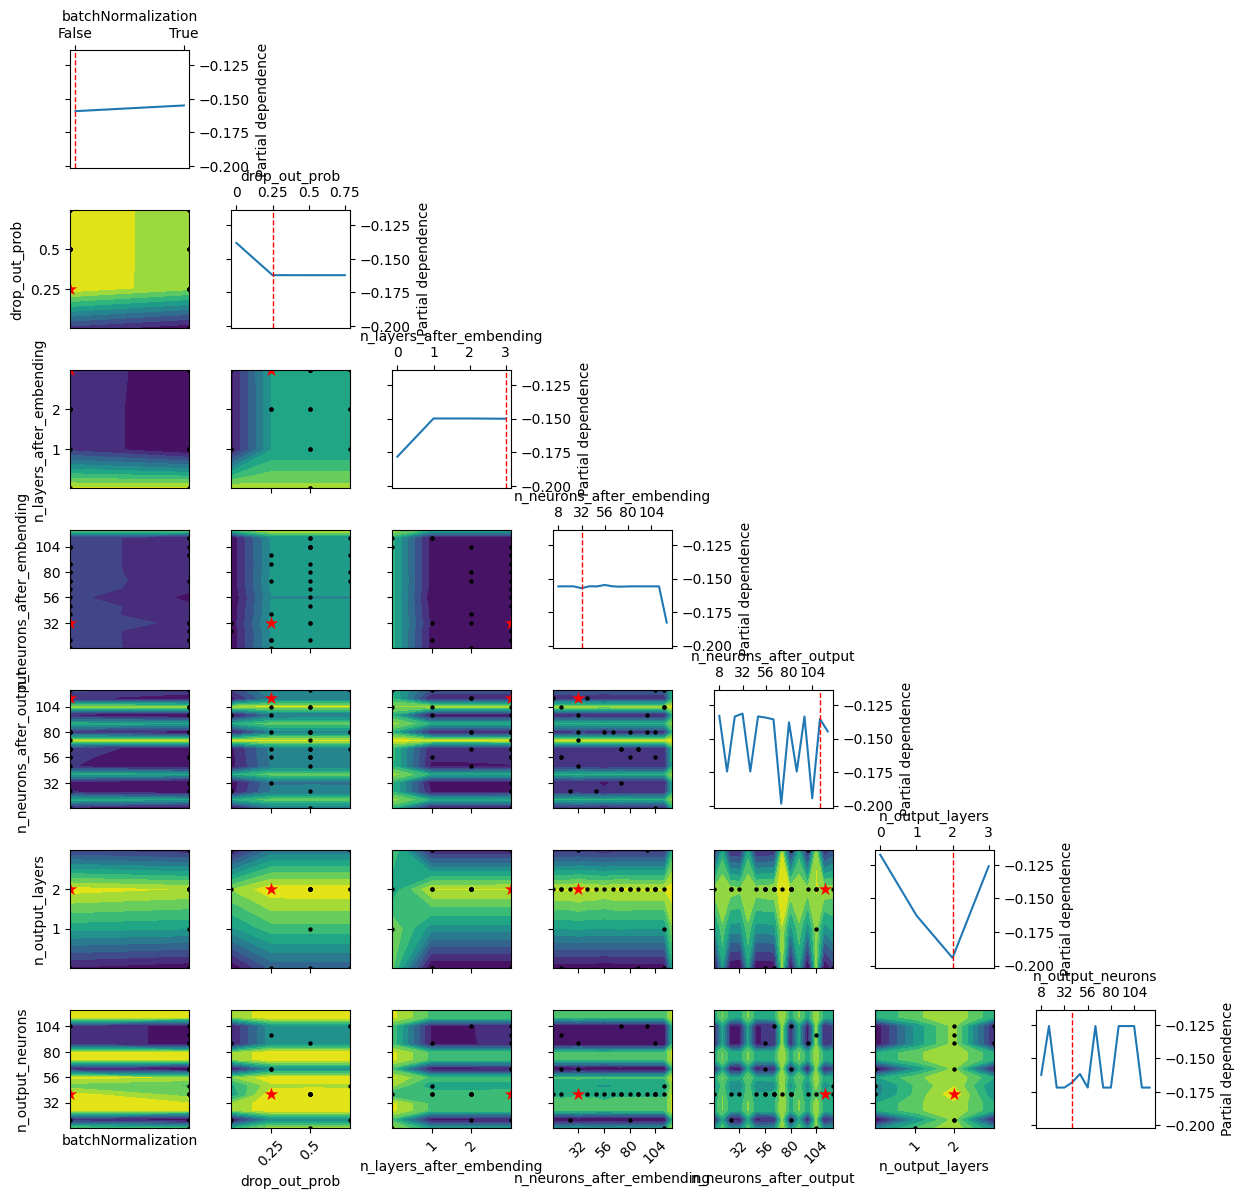

In [ ]:
# Show heatmaps that show how each value has impact on final R^2
plot_objective(opt.optimizer_results_[0])
plt.show()

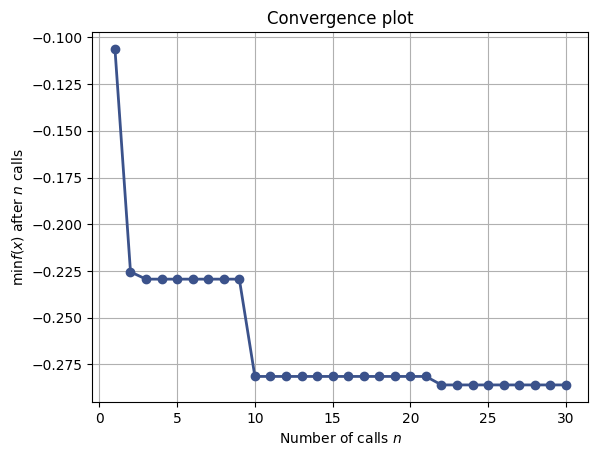

In [ ]:
# Show plot how we convergence solution
plot_convergence(opt.optimizer_results_[0])
plt.show()

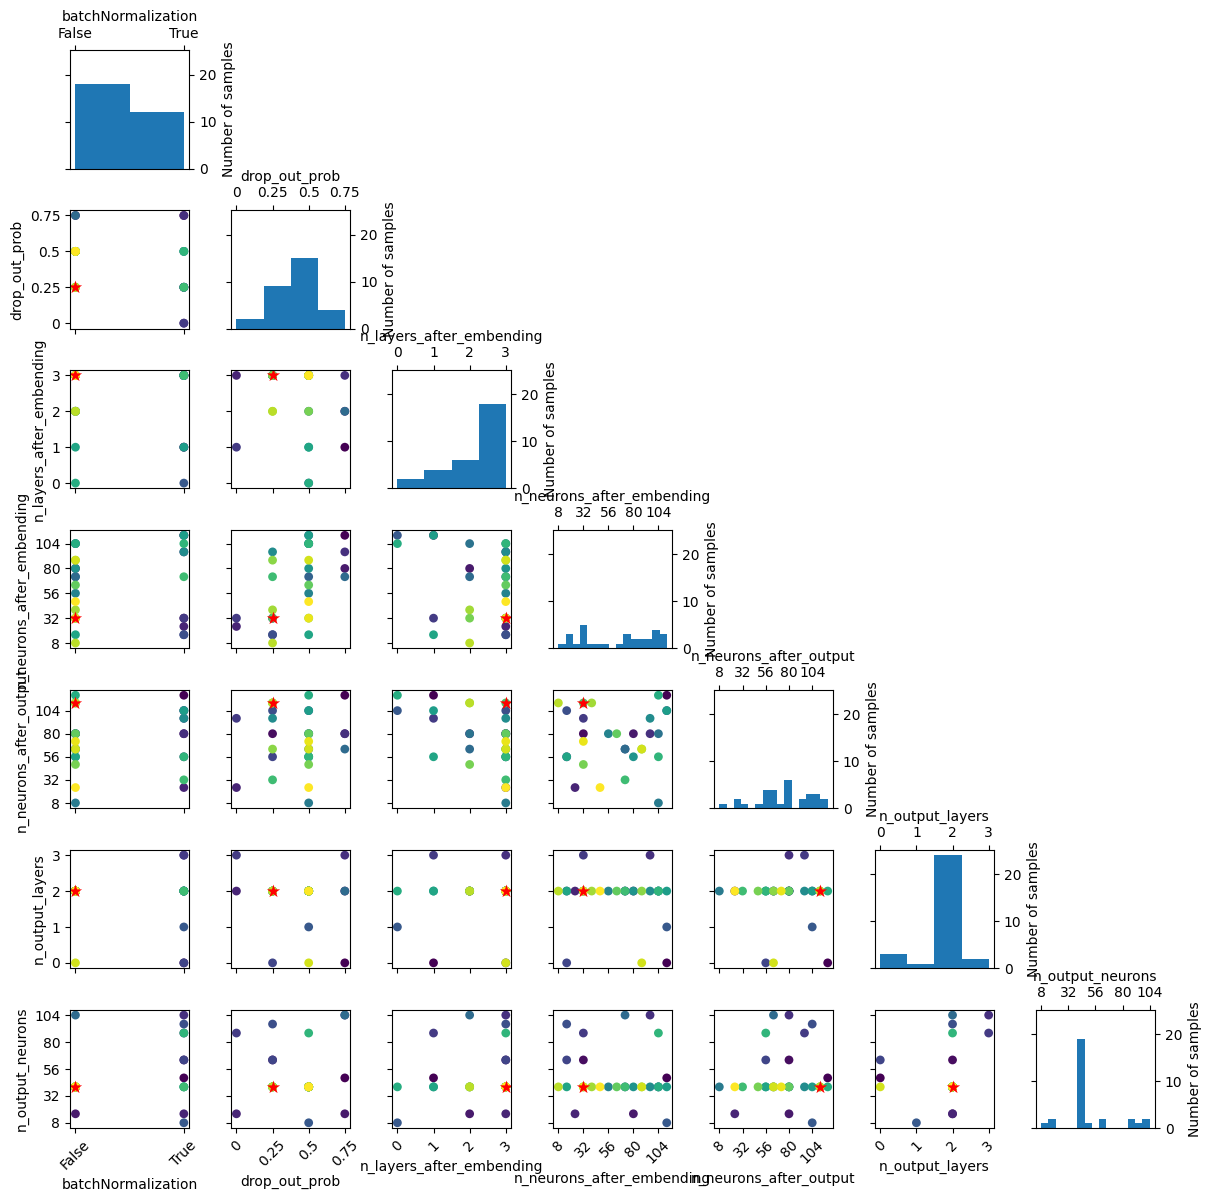

In [ ]:
# And histograms
plot_evaluations(opt.optimizer_results_[0])
plt.show()

In [100]:
# Fit model with best parametrs
filmsmodel = Filmsmodel(n_layers_after_embending = 3, n_neurons_after_embending = 32, n_neurons_after_output = 112,
                        n_output_layers = 2, n_output_neurons = 40, drop_out_prob = 0.25, batchNormalization = False)
filmsmodel.fit(np.zeros((10, )), np.zeros(10))

{'n_output_neurons': 40, 'n_layers_after_embending': 3, 'n_neurons_after_embending': 32, 'n_output_layers': 2, 'n_neurons_after_output': 112, 'drop_out_prob': 0.25, 'batchNormalization': False}
Epoch 1/50
1251/1251 [==============================] - 19s 11ms/step - loss: 1.2851 - mae: 0.8714 - val_loss: 0.8436 - val_mae: 0.7169 - lr: 0.0010
Epoch 2/50
1251/1251 [==============================] - 11s 9ms/step - loss: 0.9513 - mae: 0.7663 - val_loss: 0.9115 - val_mae: 0.7751 - lr: 0.0010
Epoch 3/50
1251/1251 [==============================] - 11s 8ms/step - loss: 0.8933 - mae: 0.7390 - val_loss: 0.8253 - val_mae: 0.7024 - lr: 0.0010
Epoch 4/50
1251/1251 [==============================] - 11s 9ms/step - loss: 0.8496 - mae: 0.7188 - val_loss: 0.8021 - val_mae: 0.6837 - lr: 0.0010
Epoch 5/50
1251/1251 [==============================] - 11s 9ms/step - loss: 0.8217 - mae: 0.7058 - val_loss: 0.8145 - val_mae: 0.6886 - lr: 0.0010
Epoch 6/50
1251/1251 [==============================] - 11s 9ms/s

0.4630217787895372

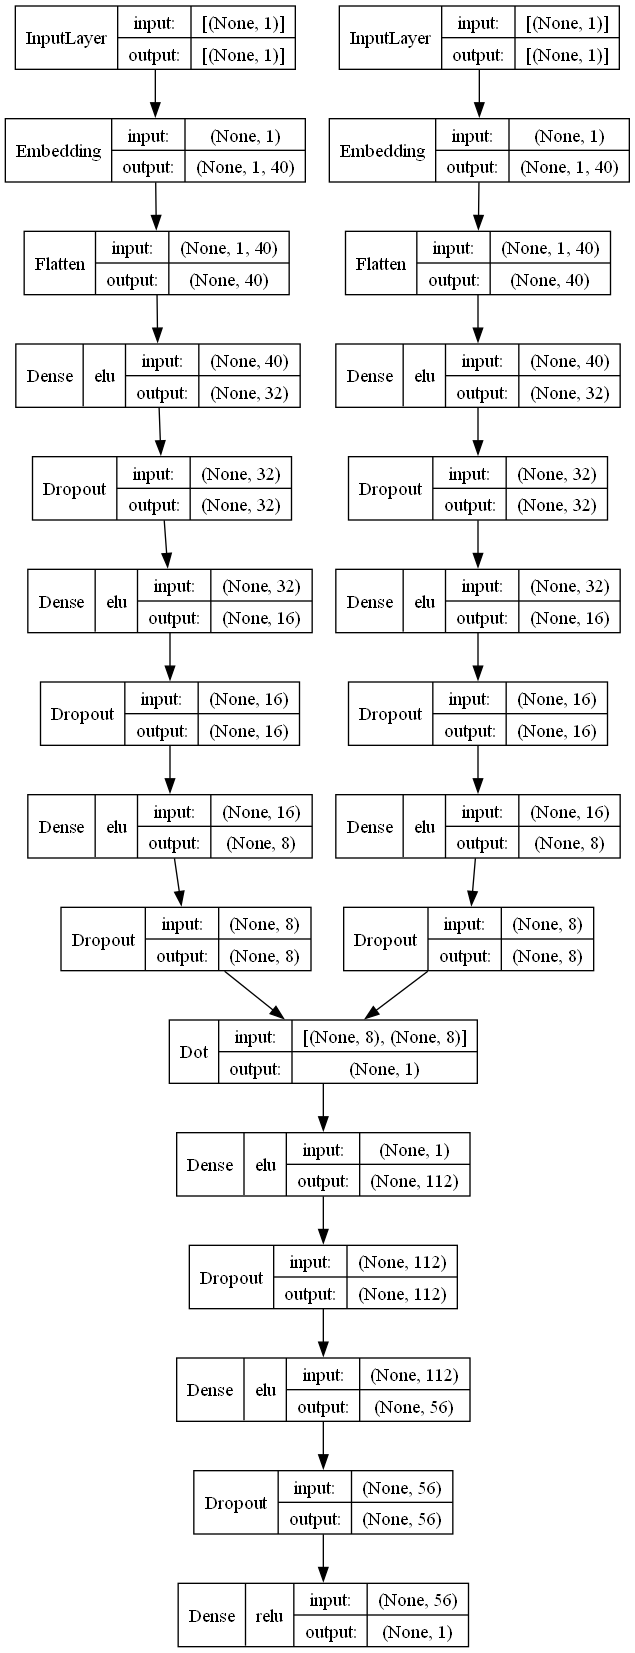

In [ ]:
plot_model(filmsmodel.model, show_shapes = True, show_layer_names = False, show_layer_activations = True)

MSE: 0.8043276610183994
RMSE: 0.8968431641142165
MAE: 0.6881780255723552
MSlogE: 0.05750967594203684
R^2: 0.2836582123187614


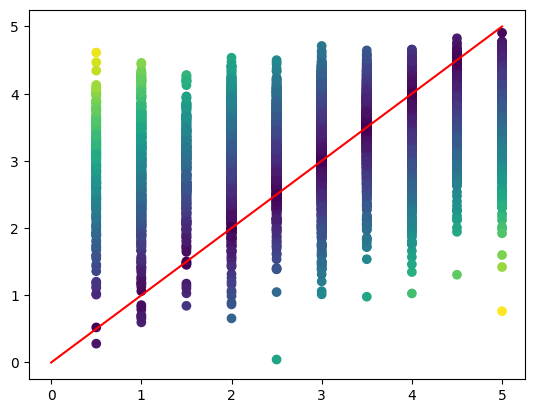

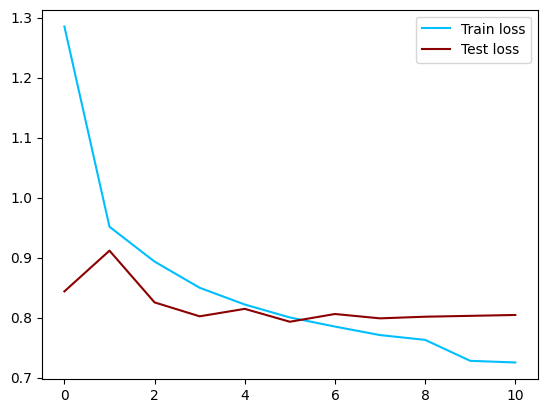

In [101]:
predicted = filmsmodel.model.predict([test['userId'], test['movieId']], verbose = False)
evaluate_model(test['rating'], predicted[:, 0], filmsmodel.history)

106696,Frozen (2013),Adventure|Animation|Comedy|Fantasy|Musical|Romance

4896,Harry Potter and the Sorcerer's Stone (a.k.a. Harry Potter and the Philosopher's Stone) (2001),Adventure|Children|Fantasy


5816,Harry Potter and the Chamber of Secrets (2002),Adventure|Fantasy
106002,Ender's Game (2013),Action|Adventure|Sci-Fi|IMAX


5873,The Emperor's Club (2002),Drama


152081,Zootopia (2016),Action|Adventure|Animation|Children|Comedy


98809,"Hobbit: An Unexpected Journey, The (2012)",Adventure|Fantasy|IMAX


106489,"Hobbit: The Desolation of Smaug, The (2013)",Adventure|Fantasy|IMAX


118696,The Hobbit: The Battle of the Five Armies (2014),Adventure|Fantasy


8368,Harry Potter and the Prisoner of Azkaban (2004),Adventure|Fantasy|IMAX


40815,Harry Potter and the Goblet of Fire (2005),Adventure|Fantasy|Thriller|IMAX


54001,Harry Potter and the Order of the Phoenix (2007),Adventure|Drama|Fantasy|IMAX


69844,Harry Potter and the Half-Blood Prince (2009),Adventure|Fantasy|Mystery|Romance|IMAX


81834,Harry Potter and the Deathly Hallows: Part 1 (2010),Action|Adventure|Fantasy|IMAX


88125,Harry Potter and the Deathly Hallows: Part 2 (2011),Action|Adventure|Drama|Fantasy|Mystery|IMAX


260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi


1196,Star Wars: Episode V - The Empire Strikes Back (1980),Action|Adventure|Sci-Fi


1210,Star Wars: Episode VI - Return of the Jedi (1983),Action|Adventure|Sci-Fi


2628,Star Wars: Episode I - The Phantom Menace (1999),Action|Adventure|Sci-Fi


5378,Star Wars: Episode II - Attack of the Clones (2002),Action|Adventure|Sci-Fi|IMAX


33493,Star Wars: Episode III - Revenge of the Sith (2005),Action|Adventure|Sci-Fi


61160,Star Wars: The Clone Wars (2008),Action|Adventure|Animation|Sci-Fi


122886,Star Wars: Episode VII - The Force Awakens (2015),Action|Adventure|Fantasy|Sci-Fi|IMAX


1907,Mulan (1998),Adventure|Animation|Children|Comedy|Drama|Musical|Romance


541,Blade Runner (1982),Action|Sci-Fi|Thriller


5952,"Lord of the Rings: The Two Towers, The (2002)",Adventure|Fantasy


7153,"Lord of the Rings: The Return of the King, The (2003)",Action|Adventure|Drama|Fantasy


4993,"Lord of the Rings: The Fellowship of the Ring, The (2001)",Adventure|Fantasy


109487,Interstellar (2014),Sci-Fi|IMAX


3147,"Green Mile, The (1999)",Crime|Drama


589,Terminator 2: Judgment Day (1991),Action|Sci-Fi


76093,How to Train Your Dragon (2010),Adventure|Animation|Children|Fantasy|IMAX


112175,How to Train Your Dragon 2 (2014),Action|Adventure|Animation


4640,Brother (2000),Action|Crime|Thriller


72605,Brothers (2009),Drama|Thriller|War


6539,Pirates of the Caribbean: The Curse of the Black Pearl (2003),Action|Adventure|Comedy|Fantasy


45722,Pirates of the Caribbean: Dead Man's Chest (2006),Action|Adventure|Fantasy


53125,Pirates of the Caribbean: At World's End (2007),Action|Adventure|Comedy|Fantasy


86880,Pirates of the Caribbean: On Stranger Tides (2011),Action|Adventure|Fantasy|IMAX


67295,Kung Fu Panda: Secrets of the Furious Five (2008),Action|Animation|Children|Comedy


72998,Avatar (2009),Action|Adventure|Sci-Fi|IMAX


1270,Back to the Future (1985),Adventure|Comedy|Sci-Fi


2011,Back to the Future Part II (1989),Adventure|Comedy|Sci-Fi


2012,Back to the Future Part III (1990),Adventure|Comedy|Sci-Fi|Western


7458,Troy (2004),Action|Adventure|Drama|War


90647,Puss in Boots (2011),Adventure|Animation|Comedy|Fantasy|IMAX


134853,Inside Out (2015),Adventure|Animation|Children|Comedy|Drama|Fantasy


7254,The Butterfly Effect (2004),Drama|Sci-Fi|Thriller

In [102]:
# Define me as user and try to get recommendations
films = [106696, 4896, 5816, 106002, 5873, 152081, 98809,
        106489, 118696, 8368, 40815, 54001, 69844, 81834,
        88125, 260, 1196, 1210, 2628, 5378, 33493, 61160,
        122886, 1907, 541, 5952, 7153, 4993, 109487, 3147,
        589, 76093, 112175, 4640, 72605, 6539, 45722, 53125,
        86880, 67295, 72998, 1270, 2011, 2012, 7458, 90647,
        134853, 7254]

for i, film in enumerate(films):
    films[i] = movieid2idx[film]

films = np.array(films)

raitings = np.array([4.5, 5, 4.5, 5, 4, 5, 4.5, 4, 4, 4.5, 3, 4, 4, 3.5, 4, 4,
                     4, 4.5, 1, 2.5, 4.5, 5, 4, 4, 4.5, 5, 5, 5, 5, 4, 4, 5, 4.5,
                     4.5, 4, 5, 4.5, 4, 3.5, 4, 5, 5, 4.5, 4.5, 4, 4.5, 5, 5])
my_user = np.ones(shape = movies.shape[0]) * (users.shape[0] + 1)

top_n = 5

In [103]:
my_predictions = filmsmodel.model.predict([my_user, np.array(sorted(movies))])

286/286 [==============================] - 1s 2ms/step


In [104]:
# Show base recomendations when model do not know enything about me
sorted_indices = np.argsort(my_predictions.flatten())[::-1]

recommended_movies_indices = sorted_indices[:top_n]

recommended_movies = df_movies.iloc[recommended_movies_indices]
predicted_ratings = my_predictions[recommended_movies_indices]

for (idx, row), raiting in zip(recommended_movies.iterrows(), predicted_ratings):
    print(row['title'])
    print(row['genres'])
    print("raiting:", raiting, "\n")

Eraser (1996)
Action|Drama|Thriller
raiting: [4.262969] 

True Crime (1996)
Mystery|Thriller
raiting: [4.260145] 

Kandahar (Safar e Ghandehar) (2001)
Drama
raiting: [4.2562366] 

Force of Evil (1948)
Film-Noir
raiting: [4.256111] 

Hi-Lo Country, The (1998)
Drama|Romance|Western
raiting: [4.252504] 



In [105]:
# Show model my reatings
my_user = np.ones(shape = len(films)) * (users.shape[0] + 1)
filmsmodel.model.fit([my_user, films], raitings, epochs = 8, batch_size = 1)

Epoch 1/8
48/48 [==============================] - 1s 7ms/step - loss: 0.9398 - mae: 0.8191
Epoch 2/8
48/48 [==============================] - 0s 7ms/step - loss: 0.5525 - mae: 0.5533
Epoch 3/8
48/48 [==============================] - 0s 6ms/step - loss: 0.6079 - mae: 0.5939
Epoch 4/8
48/48 [==============================] - 0s 7ms/step - loss: 0.5998 - mae: 0.5509
Epoch 5/8
48/48 [==============================] - 0s 9ms/step - loss: 0.5465 - mae: 0.5511
Epoch 6/8
48/48 [==============================] - 0s 9ms/step - loss: 0.5685 - mae: 0.5243
Epoch 7/8
48/48 [==============================] - 0s 7ms/step - loss: 0.5857 - mae: 0.5410
Epoch 8/8
48/48 [==============================] - 0s 8ms/step - loss: 0.5875 - mae: 0.5964


In [106]:
# and get reccomendations
my_user = np.ones(shape = movies.shape[0]) * (users.shape[0] + 1)
my_predictions = filmsmodel.model.predict([my_user, np.array(sorted(movies))])

sorted_indices = np.argsort(my_predictions.flatten())[::-1]

top_n = 5
recommended_movies_indices = sorted_indices[:top_n]

recommended_movies = df_movies.iloc[recommended_movies_indices]
predicted_ratings = my_predictions[recommended_movies_indices]

for (idx, row), raiting in zip(recommended_movies.iterrows(), predicted_ratings):
    print(row['title'])
    print(row['genres'])
    print("raiting:", raiting, "\n")

286/286 [==============================] - 1s 3ms/step
Kandahar (Safar e Ghandehar) (2001)
Drama
raiting: [4.787797] 

Eraser (1996)
Action|Drama|Thriller
raiting: [4.7872624] 

200 Cigarettes (1999)
Comedy|Drama
raiting: [4.7826486] 

Force of Evil (1948)
Film-Noir
raiting: [4.780731] 

Miracle on 34th Street (1994)
Drama
raiting: [4.7801757] 



In [30]:
# Get new range of ratings to 0-9
def convert_rating(rating):
    return round(rating * 2) - 1


train['converted_rating'] = train['rating'].apply(convert_rating)
test['converted_rating'] = test['rating'].apply(convert_rating)
test.head()

,userId,movieId,rating,timestamp,converted_rating
29675,212,363,1.5,1462640714,2
31402,226,4653,4.0,913134567,7
39453,286,6013,4.5,1469750312,8
14092,91,145,3.0,848525624,5
97982,653,1320,4.5,1145389639,8


In [31]:
# We will fit the same model
n_layers_after_embending = 3
n_neurons_after_embending = 32
n_neurons_after_output = 112
n_output_layers = 2
n_output_neurons = 40
drop_out_prob = 0.25

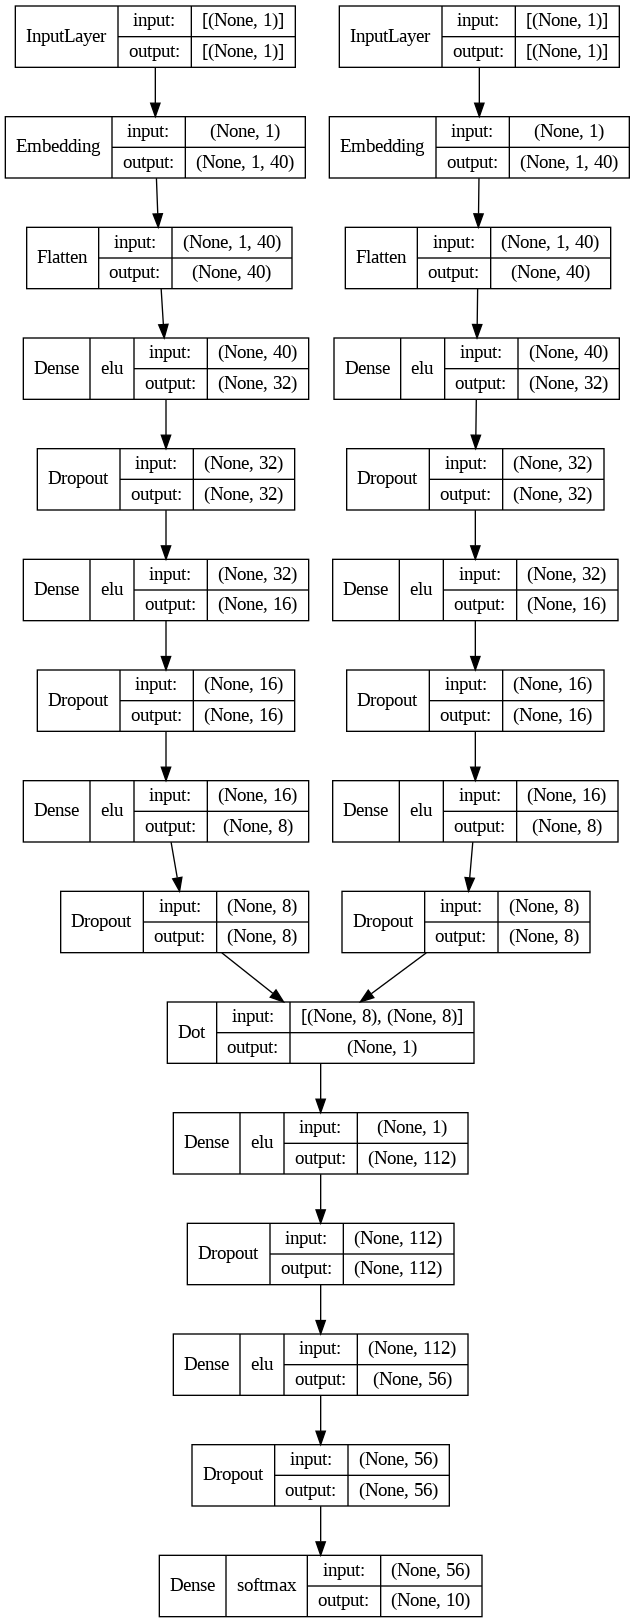

In [32]:
user_input = Input(shape = (1, ), dtype = 'int64')
user_embedding = Embedding(users.shape[0] + 1, n_output_neurons)(user_input)
user_vec = Flatten()(user_embedding)
for i in range(n_layers_after_embending):
    user_vec = Dense(n_neurons_after_embending // 2 ** (i), activation = 'elu')(user_vec)
    user_vec = Dropout(drop_out_prob)(user_vec)

movie_input = Input(shape = (1,), dtype = 'int64')
movie_embedding = Embedding(movies.shape[0], n_output_neurons)(movie_input)
movie_vec = Flatten()(movie_embedding)
for i in range(n_layers_after_embending):
    movie_vec = Dense(n_neurons_after_embending // 2 ** (i), activation = 'elu')(movie_vec)
    movie_vec = Dropout(drop_out_prob)(movie_vec)

dot = Dot(axes = 1)([user_vec, movie_vec])
for i in range(n_output_layers):
    dot = Dense(n_neurons_after_output // 2 ** (i), activation = 'elu')(dot)
    dot = Dropout(drop_out_prob)(dot)

# But have 10 classes as output with softmax
dot = Dense(10, activation = 'softmax')(dot)

# And categorical crossentropy as loss
model = Model([user_input, movie_input], dot)
model.compile(optimizer = Nadam(learning_rate = 0.001), loss = 'categorical_crossentropy', metrics = ['accuracy'])

plot_model(model, show_shapes = True, show_layer_names = False, show_layer_activations = True)

In [33]:
history = model.fit([train['userId'], train['movieId']], to_categorical(train['converted_rating']),
                            validation_data = ([test['userId'], test['movieId']], to_categorical(test['converted_rating'])),
                            batch_size = 64, epochs = 50, callbacks = [earlyStopping, reduceLR])

Epoch 1/50
1251/1251 [==============================] - 20s 12ms/step - loss: 1.8883 - accuracy: 0.2821 - val_loss: 1.8186 - val_accuracy: 0.2834 - lr: 0.0010
Epoch 2/50
1251/1251 [==============================] - 11s 9ms/step - loss: 1.8327 - accuracy: 0.2864 - val_loss: 1.8029 - val_accuracy: 0.2924 - lr: 0.0010
Epoch 3/50
1251/1251 [==============================] - 12s 9ms/step - loss: 1.8116 - accuracy: 0.2897 - val_loss: 1.7893 - val_accuracy: 0.2909 - lr: 0.0010
Epoch 4/50
1251/1251 [==============================] - 15s 12ms/step - loss: 1.7960 - accuracy: 0.2931 - val_loss: 1.7723 - val_accuracy: 0.2925 - lr: 0.0010
Epoch 5/50
1251/1251 [==============================] - 16s 12ms/step - loss: 1.7827 - accuracy: 0.2955 - val_loss: 1.7769 - val_accuracy: 0.2935 - lr: 0.0010
Epoch 6/50
1251/1251 [==============================] - 17s 14ms/step - loss: 1.7745 - accuracy: 0.2962 - val_loss: 1.7694 - val_accuracy: 0.2990 - lr: 0.0010
Epoch 7/50
1251/1251 [==========================

626/626 [==============================] - 2s 3ms/step
MSE: 0.9124403144816624
RMSE: 0.955217417388137
MAE: 0.7508485350897715
MSlogE: 0.06269653388268474
R^2: 0.18737206525926775


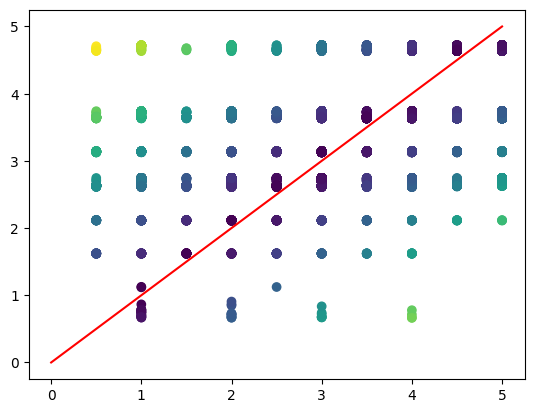

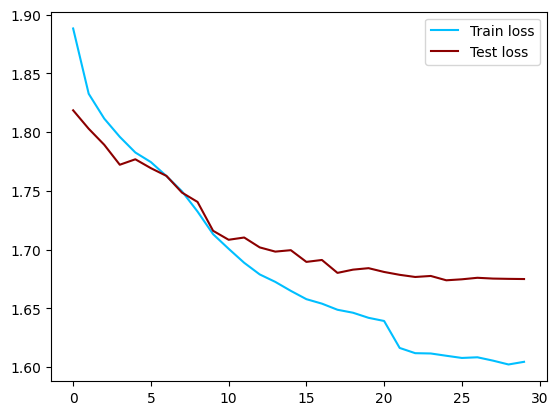

In [34]:
# No good at all
predicted = model.predict([test['userId'], test['movieId']])
max_indices = np.argmax(predicted, axis = 1)
predicted_idx = max_indices / 2 + predicted[np.arange(predicted.shape[0]), max_indices] / 2
evaluate_model(test['rating'], predicted_idx, history)

<Axes: >

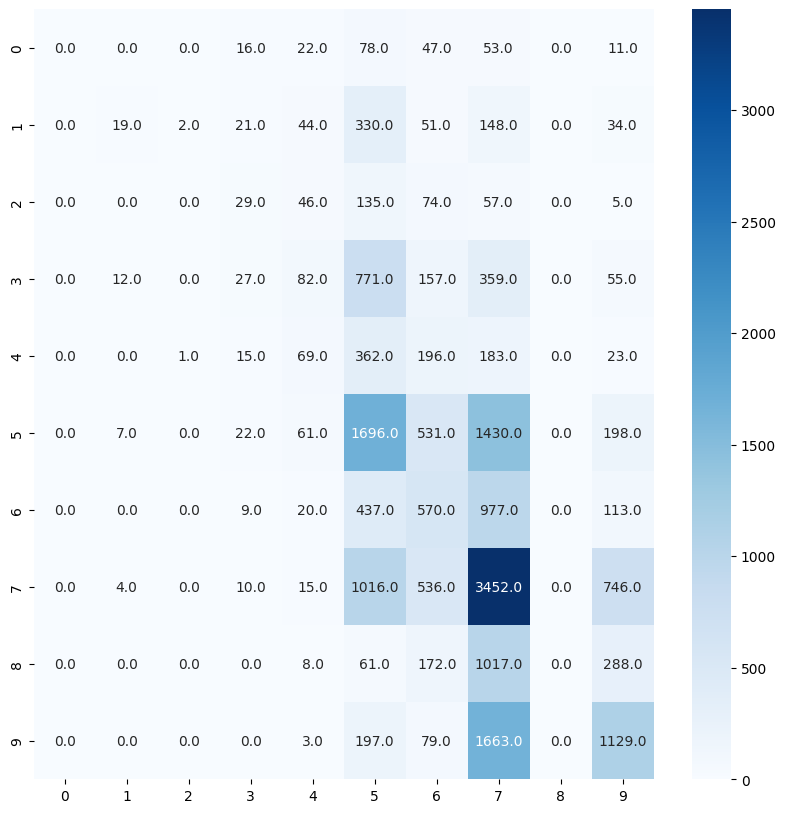

In [35]:
# Show confusion matrix
plt.figure(figsize = (10, 10))
sns.heatmap(confusion_matrix(test['converted_rating'], np.argmax(predicted, axis = 1)), cmap = 'Blues', annot = True, fmt = '.1f')

In [36]:
# And get predictions to me
converted_rating = raitings * 2 - 1

my_user = np.ones(shape = len(films)) * (users.shape[0] + 1)
model.fit([my_user, films], to_categorical(converted_rating), epochs = 8, batch_size = 1)

Epoch 1/8
48/48 [==============================] - 2s 9ms/step - loss: 1.8603 - accuracy: 0.3125
Epoch 2/8
48/48 [==============================] - 0s 10ms/step - loss: 1.7953 - accuracy: 0.3125
Epoch 3/8
48/48 [==============================] - 0s 8ms/step - loss: 1.8446 - accuracy: 0.2292
Epoch 4/8
48/48 [==============================] - 0s 9ms/step - loss: 1.7688 - accuracy: 0.2708
Epoch 5/8
48/48 [==============================] - 0s 8ms/step - loss: 1.7741 - accuracy: 0.2917
Epoch 6/8
48/48 [==============================] - 1s 11ms/step - loss: 1.7217 - accuracy: 0.4167
Epoch 7/8
48/48 [==============================] - 1s 22ms/step - loss: 1.6429 - accuracy: 0.3542
Epoch 8/8
48/48 [==============================] - 1s 20ms/step - loss: 1.6525 - accuracy: 0.3542


In [37]:
# Get Dramma and Commedy as recomendations
my_user = np.ones(shape = movies.shape[0]) * (users.shape[0] + 1)
my_predictions = model.predict([my_user, np.array(sorted(movies))])

max_indices = np.argmax(my_predictions, axis = 1)
my_predictions = max_indices / 2 + my_predictions[np.arange(my_predictions.shape[0]), max_indices] / 2

sorted_indices = np.argsort(my_predictions.flatten())[::-1]

recommended_movies_indices = sorted_indices[:top_n]

recommended_movies = df_movies.iloc[recommended_movies_indices]
predicted_ratings = my_predictions[recommended_movies_indices]

for (idx, row), raiting in zip(recommended_movies.iterrows(), predicted_ratings):
    print(row['title'])
    print(row['genres'])
    print("raiting:", raiting, "\n")

284/284 [==============================] - 1s 4ms/step
Melvin Goes to Dinner (2003)
Comedy|Drama
raiting: 4.726850733160973 

Gray's Anatomy (1996)
Comedy|Drama
raiting: 4.726844549179077 

Suddenly (1954)
Crime|Drama|Film-Noir
raiting: 4.726826444268227 

Imaginary Crimes (1994)
Drama
raiting: 4.7268099039793015 

Broken Wings (Knafayim Shvurot) (2002)
Drama
raiting: 4.726804703474045 



In [38]:
# Cout inverse weight to each movie, more ratings have movie -> less weight
movie_counts = df.groupby('movieId').size()
total_counts = movie_counts.sum()
df['movie_weight'] = 1 - movie_counts[df['movieId']].values * 1000 / total_counts
df['movie_weight'] = df['movie_weight'].fillna(1)
df.head()

,userId,movieId,rating,timestamp,movie_weight
0,0,0,2.5,1260759144,0.580017
1,0,1,3.0,1260759179,0.580017
2,0,2,3.0,1260759182,0.670013
3,0,3,2.0,1260759185,0.520019
4,0,4,4.0,1260759205,0.540018


In [39]:
train, test = train_test_split(df, train_size = 0.8, random_state = 1212)

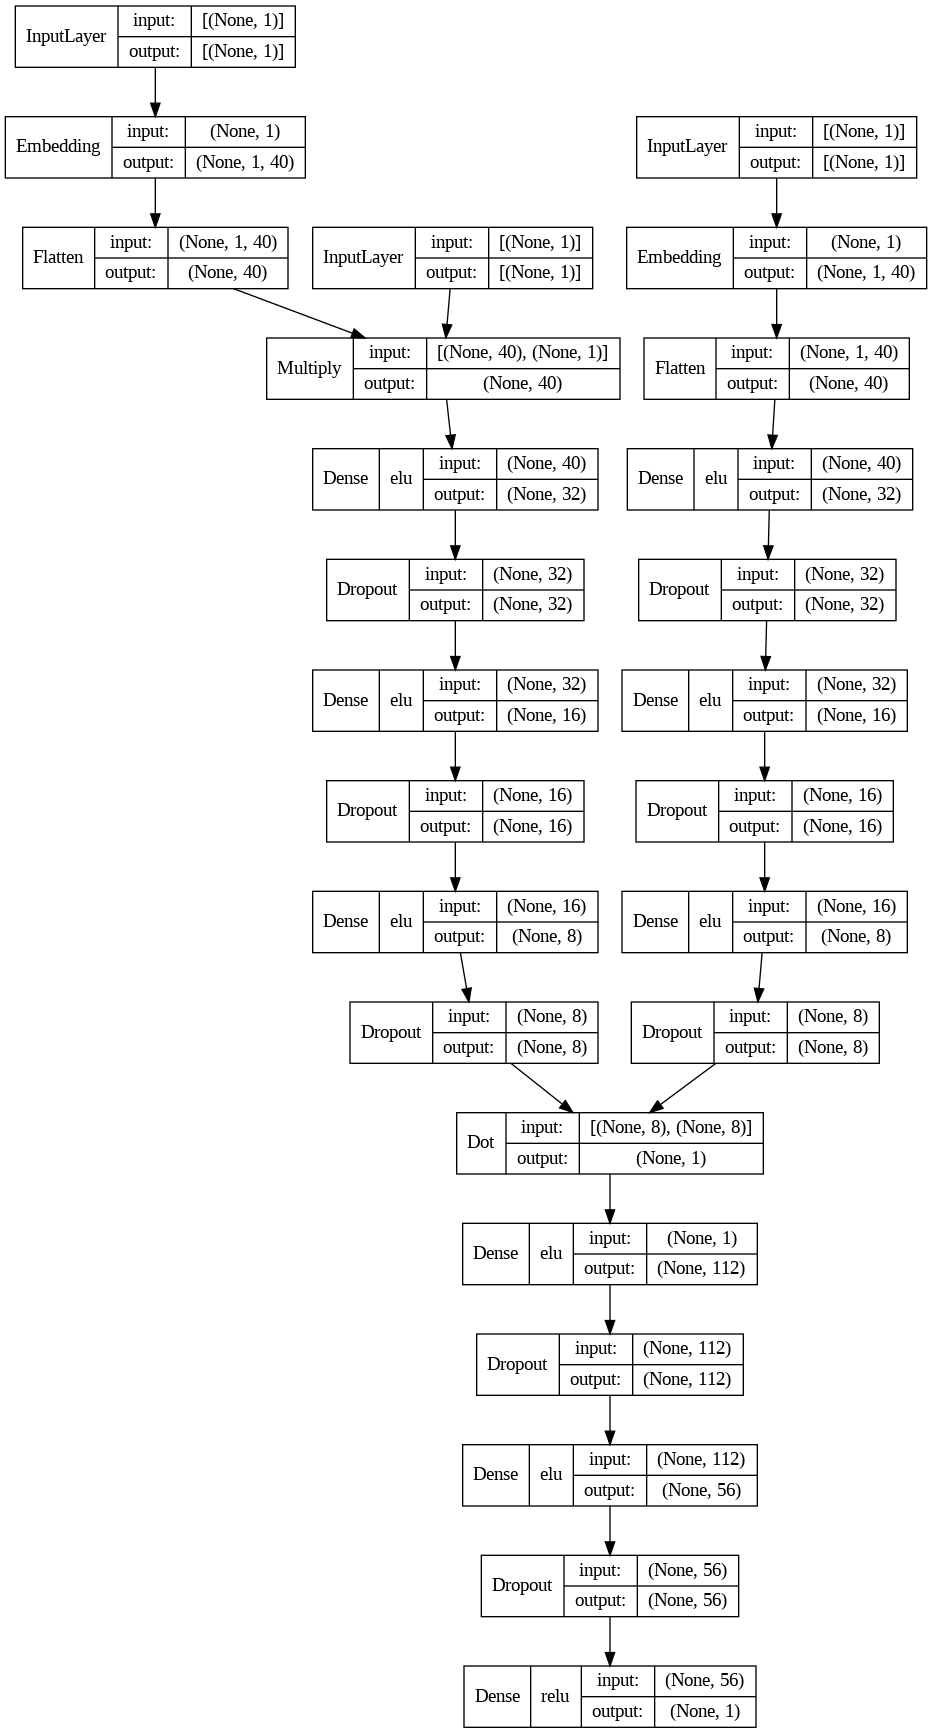

In [40]:
# Fit this model
user_input = Input(shape = (1, ), dtype = 'int64')
user_embedding = Embedding(users.shape[0] + 1, n_output_neurons)(user_input)
user_vec = Flatten()(user_embedding)
for i in range(n_layers_after_embending):
    user_vec = Dense(n_neurons_after_embending // 2 ** (i), activation = 'elu')(user_vec)
    user_vec = Dropout(drop_out_prob)(user_vec)

movie_input = Input(shape = (1, ), dtype = 'int64')
movie_embedding = Embedding(movies.shape[0], n_output_neurons)(movie_input)
movie_vec = Flatten()(movie_embedding)

movie_weight_input = Input(shape = (1, ))
movie_vec = Multiply()([movie_vec, movie_weight_input])

for i in range(n_layers_after_embending):
    movie_vec = Dense(n_neurons_after_embending // 2 ** (i), activation = 'elu')(movie_vec)
    movie_vec = Dropout(drop_out_prob)(movie_vec)

dot = Dot(axes = 1)([user_vec, movie_vec])
for i in range(n_output_layers):
    dot = Dense(n_neurons_after_output // 2 ** (i), activation = 'elu')(dot)
    dot = Dropout(drop_out_prob)(dot)

dot = Dense(1, activation = 'relu')(dot)

model = Model([user_input, movie_input, movie_weight_input], dot)
model.compile(optimizer = Nadam(learning_rate = 0.001), loss = 'mse', metrics = ['mae'])

plot_model(model, show_shapes = True, show_layer_names = False, show_layer_activations = True)

In [41]:
history = model.fit([train['userId'], train['movieId'], train['movie_weight']], train['rating'],
                            validation_data = ([test['userId'], test['movieId'], test['movie_weight']], test['rating']),
                            batch_size = 64, epochs = 50, callbacks = [earlyStopping, reduceLR])


Epoch 1/50
1251/1251 [==============================] - 34s 21ms/step - loss: 1.2874 - mae: 0.8716 - val_loss: 0.8550 - val_mae: 0.7279 - lr: 0.0010
Epoch 2/50
1251/1251 [==============================] - 16s 13ms/step - loss: 0.9455 - mae: 0.7626 - val_loss: 0.8156 - val_mae: 0.6979 - lr: 0.0010
Epoch 3/50
1251/1251 [==============================] - 14s 11ms/step - loss: 0.8824 - mae: 0.7355 - val_loss: 0.8105 - val_mae: 0.6995 - lr: 0.0010
Epoch 4/50
1251/1251 [==============================] - 15s 12ms/step - loss: 0.8440 - mae: 0.7179 - val_loss: 0.8139 - val_mae: 0.6964 - lr: 0.0010
Epoch 5/50
1251/1251 [==============================] - 17s 14ms/step - loss: 0.8254 - mae: 0.7088 - val_loss: 0.8280 - val_mae: 0.7046 - lr: 0.0010
Epoch 6/50
1250/1251 [============================>.] - ETA: 0s - loss: 0.8036 - mae: 0.6987
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
1251/1251 [==============================] - 18s 14ms/step - loss: 0.8036 - mae: 0.69

MSE: 0.8095288747134374
RMSE: 0.8997382256597957
MAE: 0.6919589697417662
MSlogE: 0.0578764136402155
R^2: 0.27902596243231803


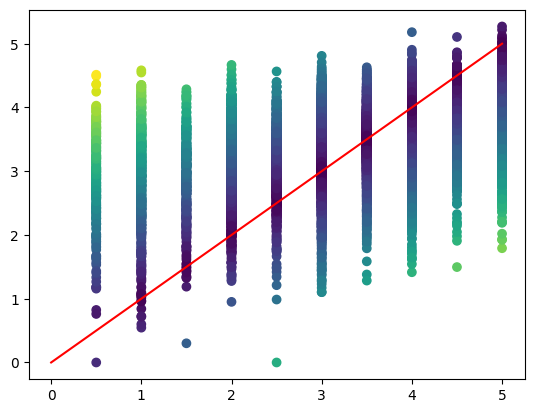

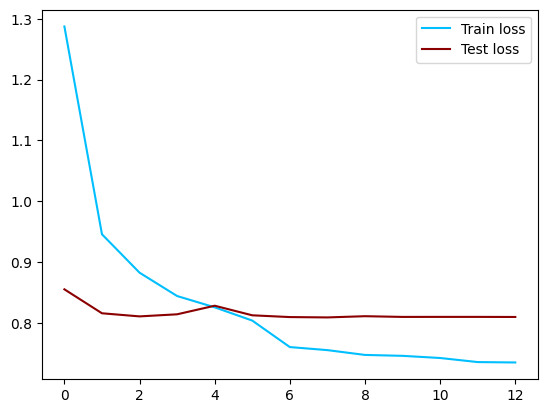

In [42]:
# Seems nothings change
predicted = model.predict([test['userId'], test['movieId'], test['movie_weight']], verbose = False)
evaluate_model(test['rating'], predicted[:, 0], history)

In [43]:
unique_movies = df.drop_duplicates(subset = 'movieId')

In [44]:
# Get commedy as recomendations...
my_user = np.ones(shape = len(films)) * (users.shape[0] + 1)
model.fit([my_user, films, np.ones(shape = len(films))], raitings, epochs = 8, batch_size = 1, verbose = False)

my_user = np.ones(shape = movies.shape[0]) * (users.shape[0] + 1)
my_predictions = model.predict([my_user, np.array(sorted(movies)), unique_movies['movie_weight']])

sorted_indices = np.argsort(my_predictions.flatten())[::-1]

top_n = 5
recommended_movies_indices = sorted_indices[:top_n]

recommended_movies = df_movies.iloc[recommended_movies_indices]
predicted_ratings = my_predictions[recommended_movies_indices]

for (idx, row), raiting in zip(recommended_movies.iterrows(), predicted_ratings):
    print(row['title'])
    print(row['genres'])
    print("raiting:", raiting, "\n")

284/284 [==============================] - 1s 3ms/step
Hudsucker Proxy, The (1994)
Comedy
raiting: [4.425927] 

Reckless (1995)
Comedy|Fantasy
raiting: [4.42531] 

Rock, The (1996)
Action|Adventure|Thriller
raiting: [4.4234056] 

Hard Target (1993)
Action|Adventure|Crime|Thriller
raiting: [4.421013] 

Chasers (1994)
Comedy
raiting: [4.4180713] 



In [45]:
# Try SVD
reader = Reader()
data = Dataset.load_from_df(df_ratings[['userId', 'movieId', 'rating']], reader)
train, test = __train_test_split__(data, train_size = 0.8, random_state = 1212)

In [46]:
algo = SVD()
algo.fit(train)

predictions = algo.test(test)

MSE: 0.7956543184952017
RMSE: 0.8919945731310263
MAE: 0.6882805813786291
MSlogE: 0.056544882166120594
R^2: 0.28418400952160516


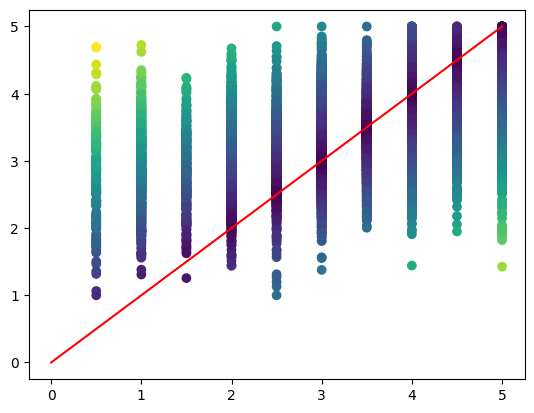

In [47]:
true_values = np.array([pred.r_ui for pred in predictions])
predicted_values = np.array([pred.est for pred in predictions])

evaluate_model(true_values, predicted_values)

In [48]:
# Add my user to whole data frame
for i, (film, rating) in enumerate(zip(films, raitings)):
    df_ratings.loc[len(df) + 1 + i] = [users.shape[0] + 1, film, rating, 1]


df_ratings.head()

,userId,movieId,rating,timestamp
0,1.0,31.0,2.5,1.260759e+09
1,1.0,1029.0,3.0,1.260759e+09
2,1.0,1061.0,3.0,1.260759e+09
3,1.0,1129.0,2.0,1.260759e+09
4,1.0,1172.0,4.0,1.260759e+09


In [49]:
train, test = __train_test_split__(data, train_size = 0.8, random_state = 1212)
algo = SVD()
algo.fit(train)

predictions = algo.test(test)

true_values = np.array([pred.r_ui for pred in predictions])
predicted_values = np.array([pred.est for pred in predictions])

In [50]:
# And get Crimes at preditions...
predictions = [algo.predict(users.shape[0] + 1, i) for i in np.array(sorted(movies))]

sorted_predictions = sorted(predictions, key = lambda x: x.est, reverse = True)[: top_n]

for pred in sorted_predictions:
    movie_info = df_movies.iloc[pred.iid]
    print(movie_info['title'])
    print(movie_info['genres'])
    print("rating:", pred.est)
    print()

Crow, The (1994)
Action|Crime|Fantasy|Thriller
rating: 4.457817639953301

Goodfellas (1990)
Crime|Drama
rating: 4.425537479177343

Baby Boy (2001)
Crime|Drama
rating: 4.413224629428118

Swingers (1996)
Comedy|Drama
rating: 4.400986853900281

Truth or Consequences, N.M. (1997)
Action|Crime|Romance
rating: 4.374944201162972



In [77]:
# Get ganeras as new features for movies using tf-idf
df_movies = pd.read_csv(open("movies.csv", 'rb'))
df_movies['genres'] = df_movies['genres'].apply(lambda x : x.replace("|", " "))
df_movies['year'] = df_movies['title'].str.extract(r'\((\d{4})\)').fillna('2000').astype("int64")

tfidf = TfidfVectorizer(analyzer = 'word', stop_words = 'english')
genres_tfidf = tfidf.fit_transform(df_movies['genres'])
genres_tfidf_df = pd.DataFrame(genres_tfidf.toarray(), columns = tfidf.get_feature_names_out())
df_movies = pd.concat([df_movies, genres_tfidf_df], axis=1)
df_movies = df_movies.drop('genres', axis = 1)

df_movies.head()

,movieId,title,year,action,adventure,animation,children,comedy,crime,documentary,...,imax,listed,musical,mystery,noir,romance,sci,thriller,war,western
0,1,Toy Story (1995),1995,0.0,0.410433,0.531527,0.496423,0.266469,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
1,2,Jumanji (1995),1995,0.0,0.510466,0.000000,0.617414,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
2,3,Grumpier Old Men (1995),1995,0.0,0.000000,0.000000,0.000000,0.586999,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.809588,0.0,0.0,0.0,0.0
3,4,Waiting to Exhale (1995),1995,0.0,0.000000,0.000000,0.000000,0.523605,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.722155,0.0,0.0,0.0,0.0
4,5,Father of the Bride Part II (1995),1995,0.0,0.000000,0.000000,0.000000,1.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0


In [78]:
ganers = ['action', 'adventure', 'animation', 'children', 'comedy', 'crime',
          'documentary', 'drama', 'fantasy', 'fi', 'film', 'horror', 'imax',
          'musical', 'listed', 'musical', 'mystery', 'noir', 'romance',
          'sci', 'thriller', 'war', 'western']

In [79]:
# Get some features for user
df_ratings = pd.read_csv("ratings.csv")

user_avg_ratings = df_ratings.groupby('userId')['rating'].mean()
df_ratings = pd.merge(df_ratings, user_avg_ratings.rename('user_avg_rating'), left_on = 'userId', right_index = True)

user_med_ratings = df_ratings.groupby('userId')['rating'].median()
df_ratings = pd.merge(df_ratings, user_med_ratings.rename('user_med_rating'), left_on = 'userId', right_index = True)

user_std_ratings = df_ratings.groupby('userId')['rating'].std()
df_ratings = pd.merge(df_ratings, user_std_ratings.rename('user_std_rating'), left_on = 'userId', right_index = True)

user_1quantile_ratings = df_ratings.groupby('userId')['rating'].quantile(0.25)
df_ratings = pd.merge(df_ratings, user_1quantile_ratings.rename('user_1quantile_rating'), left_on = 'userId', right_index = True)

user_3quantile_ratings = df_ratings.groupby('userId')['rating'].quantile(0.75)
df_ratings = pd.merge(df_ratings, user_3quantile_ratings.rename('user_3quantile_rating'), left_on = 'userId', right_index = True)

user_skew_ratings = df_ratings.groupby('userId')['rating'].skew()
df_ratings = pd.merge(df_ratings, user_skew_ratings.rename('user_skew_rating'), left_on = 'userId', right_index = True)

users_featurs = ['user_avg_rating', 'user_med_rating', 'user_std_rating',
                 'user_1quantile_rating', 'user_3quantile_rating', 'user_skew_rating']

df_ratings.head(5)

,userId,movieId,rating,timestamp,user_avg_rating,user_med_rating,user_std_rating,user_1quantile_rating,user_3quantile_rating,user_skew_rating
0,1,31,2.5,1260759144,2.55,2.5,0.887041,2.0,3.0,0.147045
1,1,1029,3.0,1260759179,2.55,2.5,0.887041,2.0,3.0,0.147045
2,1,1061,3.0,1260759182,2.55,2.5,0.887041,2.0,3.0,0.147045
3,1,1129,2.0,1260759185,2.55,2.5,0.887041,2.0,3.0,0.147045
4,1,1172,4.0,1260759205,2.55,2.5,0.887041,2.0,3.0,0.147045


In [80]:
# And set new indexes
userid2idx = {o: i for i, o in enumerate(users)}
movieid2idx = {o: i for i, o in enumerate(movies)}
df = df_ratings.copy(deep = True)
df['userId'] = df['userId'].apply(lambda x: userid2idx[x])
df['movieId'] = df['movieId'].apply(lambda x: movieid2idx[x])
df.head()

,userId,movieId,rating,timestamp,user_avg_rating,user_med_rating,user_std_rating,user_1quantile_rating,user_3quantile_rating,user_skew_rating
0,0,30,2.5,1260759144,2.55,2.5,0.887041,2.0,3.0,0.147045
1,0,833,3.0,1260759179,2.55,2.5,0.887041,2.0,3.0,0.147045
2,0,859,3.0,1260759182,2.55,2.5,0.887041,2.0,3.0,0.147045
3,0,906,2.0,1260759185,2.55,2.5,0.887041,2.0,3.0,0.147045
4,0,931,4.0,1260759205,2.55,2.5,0.887041,2.0,3.0,0.147045


In [81]:
# Set movies features to while df
df[ganers] = 0.0
for i in range(len(df)):
    df.iloc[i, 10 :] = df_movies.iloc[df.iloc[i, 1], 3 : ].astype("float64")

df.head()

,userId,movieId,rating,timestamp,user_avg_rating,user_med_rating,user_std_rating,user_1quantile_rating,user_3quantile_rating,user_skew_rating,...,imax,musical,listed,mystery,noir,romance,sci,thriller,war,western
0,0,30,2.5,1260759144,2.55,2.5,0.887041,2.0,3.0,0.147045,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
1,0,833,3.0,1260759179,2.55,2.5,0.887041,2.0,3.0,0.147045,...,0.0,0.0,0.583588,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
2,0,859,3.0,1260759182,2.55,2.5,0.887041,2.0,3.0,0.147045,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,1.000000,0.0,0.0
3,0,906,2.0,1260759185,2.55,2.5,0.887041,2.0,3.0,0.147045,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.496387,0.383926,0.0,0.0
4,0,931,4.0,1260759205,2.55,2.5,0.887041,2.0,3.0,0.147045,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0


In [82]:
train, test = train_test_split(df, train_size = 0.8, random_state = 1212)

In [83]:
# And scale data
standartScaler = StandardScaler()
train['user_avg_rating'] = standartScaler.fit_transform(train[users_featurs])
test['user_avg_rating'] = standartScaler.transform(test[users_featurs])

minMaxScaler = MinMaxScaler()
train['rating'] = minMaxScaler.fit_transform(train['rating'].values.reshape(-1, 1))
test['rating'] = minMaxScaler.transform(test['rating'].values.reshape(-1, 1))

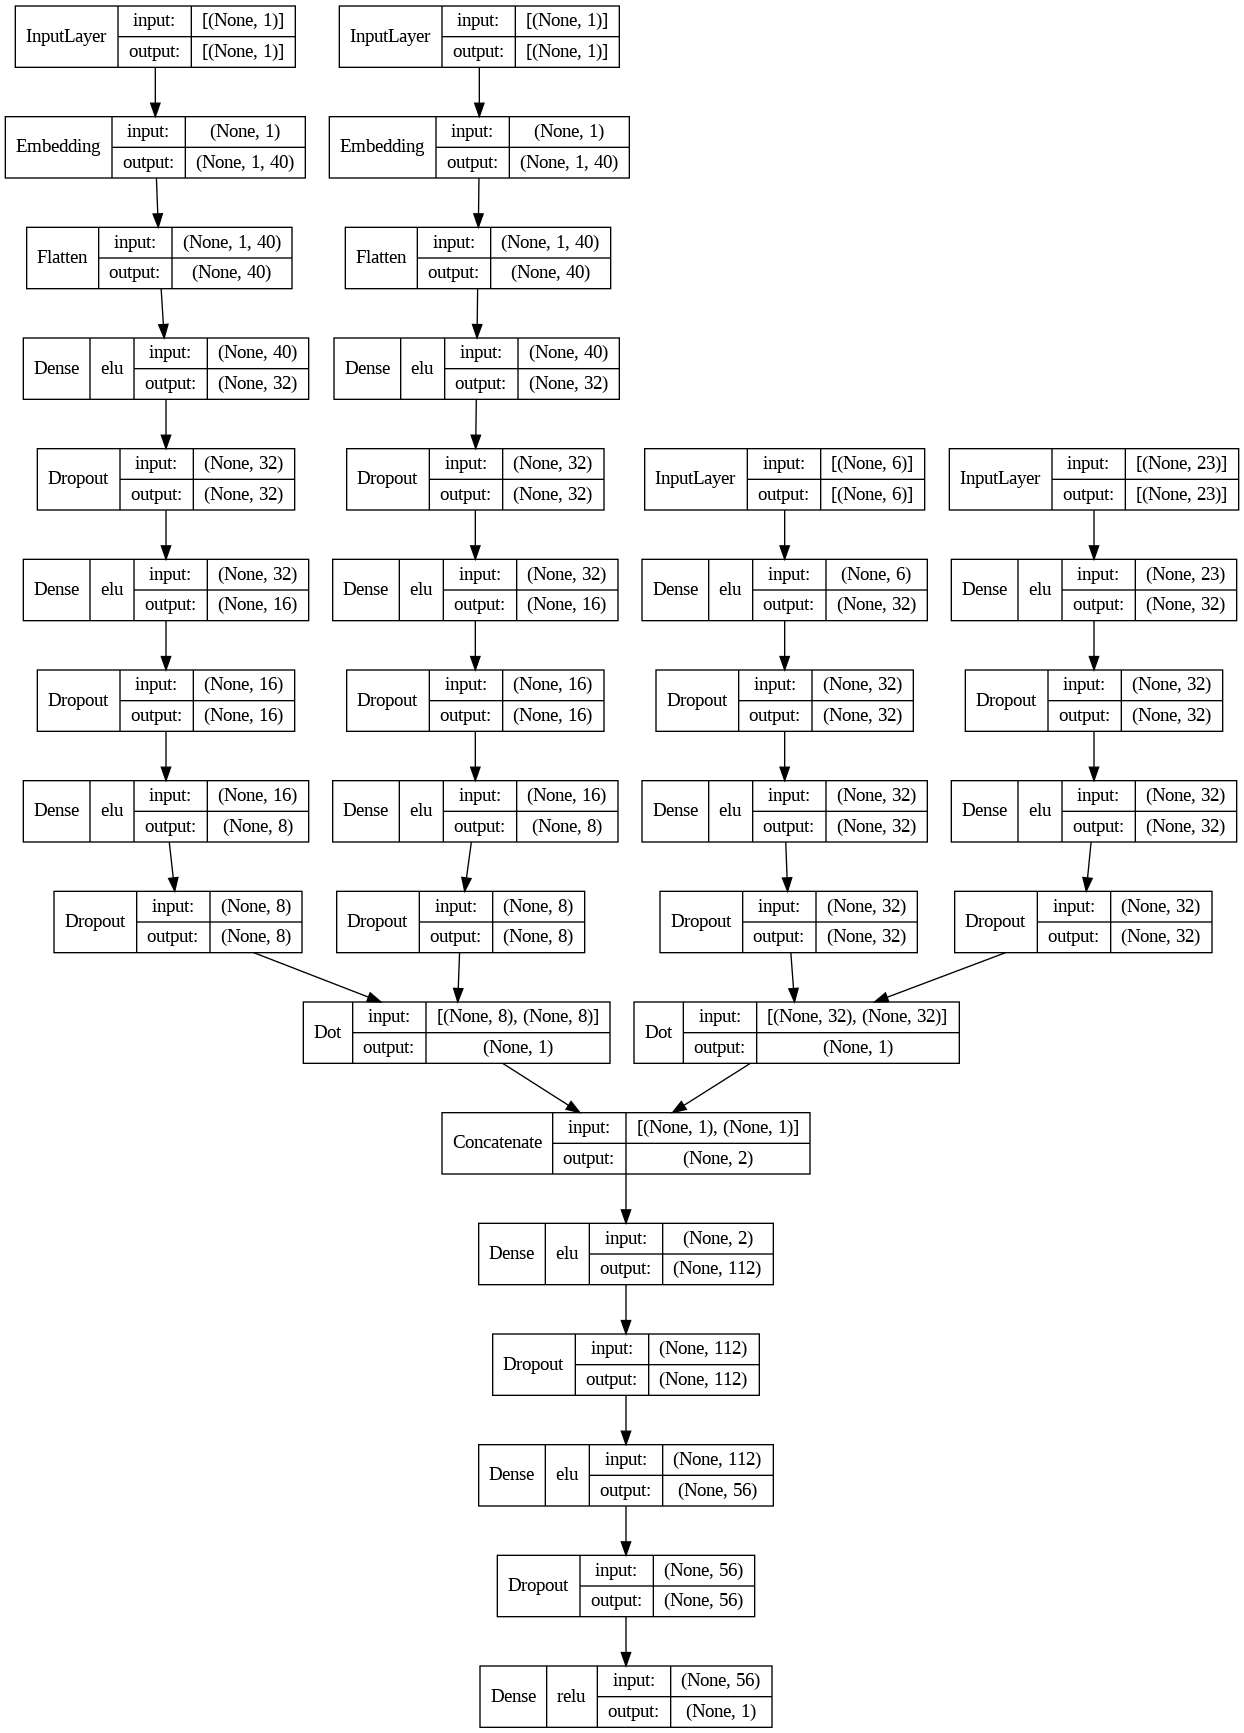

In [84]:
user_input = Input(shape = (1, ), dtype = 'int64')
user_embedding = Embedding(users.shape[0] + 1, n_output_neurons)(user_input)
user_vec = Flatten()(user_embedding)
for i in range(n_layers_after_embending):
    user_vec = Dense(n_neurons_after_embending // 2 ** (i), activation = 'elu')(user_vec)
    user_vec = Dropout(drop_out_prob)(user_vec)

movie_input = Input(shape = (1, ), dtype = 'int64')
movie_embedding = Embedding(movies.shape[0], n_output_neurons)(movie_input)
movie_vec = Flatten()(movie_embedding)
for i in range(n_layers_after_embending):
    movie_vec = Dense(n_neurons_after_embending // 2 ** (i), activation = 'elu')(movie_vec)
    movie_vec = Dropout(drop_out_prob)(movie_vec)

dot_embending = Dot(axes = 1)([user_vec, movie_vec])

# Get input for users features
user_feature_input = Input(shape = (len(users_featurs), ))
user_feature = Dense(32, activation = 'elu')(user_feature_input)
user_feature = Dropout(drop_out_prob)(user_feature)
user_feature = Dense(32, activation = 'elu')(user_feature)
user_feature = Dropout(drop_out_prob)(user_feature)

# Get input for movies featurs
movies_feature_input = Input(shape = (len(ganers), ))
movies_feature = Dense(32, activation = 'elu')(movies_feature_input)
movies_feature = Dropout(drop_out_prob)(movies_feature)
movies_feature = Dense(32, activation = 'elu')(movies_feature)
movies_feature = Dropout(drop_out_prob)(movies_feature)

# Dot it
dot_features = Dot(axes = 1)([user_feature, movies_feature])

dot = concatenate([dot_embending, dot_features])

for i in range(n_output_layers):
    dot = Dense(n_neurons_after_output // 2 ** (i), activation = 'elu')(dot)
    dot = Dropout(drop_out_prob)(dot)

dot = Dense(1, activation = 'relu')(dot)

model = Model([user_input, movie_input, user_feature_input, movies_feature_input], dot)
model.compile(optimizer = Nadam(learning_rate = 0.001), loss = 'mse', metrics = ['mae'])

plot_model(model, show_shapes = True, show_layer_names = False, show_layer_activations = True)

In [85]:
history = model.fit([train['userId'], train['movieId'], train[users_featurs], train[ganers]], train['rating'],
                            validation_data = ([test['userId'], test['movieId'],
                                                test[users_featurs], test[ganers]], test['rating']),
                            batch_size = 64, epochs = 50, callbacks = [earlyStopping, reduceLR])

Epoch 1/50
1251/1251 [==============================] - 26s 15ms/step - loss: 0.0577 - mae: 0.1865 - val_loss: 0.0416 - val_mae: 0.1575 - lr: 0.0010
Epoch 2/50
1251/1251 [==============================] - 15s 12ms/step - loss: 0.0433 - mae: 0.1625 - val_loss: 0.0406 - val_mae: 0.1542 - lr: 0.0010
Epoch 3/50
1251/1251 [==============================] - 17s 14ms/step - loss: 0.0394 - mae: 0.1539 - val_loss: 0.0392 - val_mae: 0.1537 - lr: 0.0010
Epoch 4/50
1251/1251 [==============================] - 18s 14ms/step - loss: 0.0374 - mae: 0.1496 - val_loss: 0.0386 - val_mae: 0.1501 - lr: 0.0010
Epoch 5/50
1251/1251 [==============================] - 15s 12ms/step - loss: 0.0362 - mae: 0.1469 - val_loss: 0.0391 - val_mae: 0.1532 - lr: 0.0010
Epoch 6/50
1251/1251 [==============================] - 14s 11ms/step - loss: 0.0354 - mae: 0.1449 - val_loss: 0.0390 - val_mae: 0.1520 - lr: 0.0010
Epoch 7/50
1249/1251 [============================>.] - ETA: 0s - loss: 0.0350 - mae: 0.1438
Epoch 7: Redu

MSE: 0.7885182021739504
RMSE: 0.8879854740782365
MAE: 0.6788506307850348
MSlogE: 0.05645688635250813
R^2: 0.2977382652123378


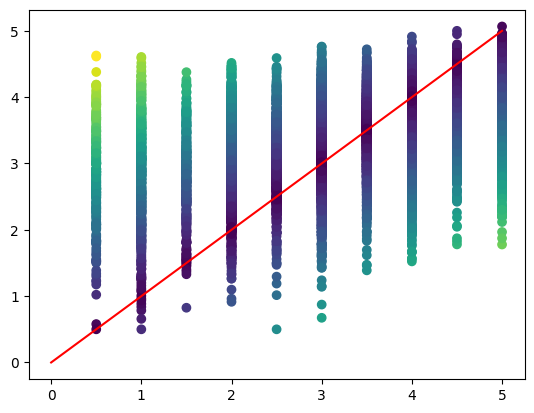

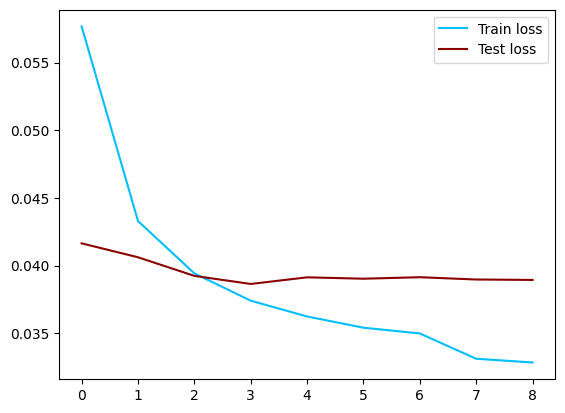

In [86]:
predicted = model.predict([test['userId'], test['movieId'], test[users_featurs], test[ganers]], verbose = False)
evaluate_model(minMaxScaler.inverse_transform(test['rating'].values.reshape(-1, 1)),
               minMaxScaler.inverse_transform(predicted[:, 0].reshape(-1, 1)),
               history)

In [87]:
# And get recomendations for my user
df_movies['movieId'] = df_movies['movieId'].apply(lambda x: movieid2idx[x])
fils_featurs = df_movies[df_movies['movieId'].isin(films)]
my_avg = np.ones(shape = len(films)) * raitings.mean()
my_med = np.ones(shape = len(films)) * np.median(raitings)
my_std = np.ones(shape = len(films)) * raitings.std()
my_1 = np.ones(shape = len(films)) * np.quantile(raitings, q = 0.25)
my_2 = np.ones(shape = len(films)) * np.quantile(raitings, q = 0.75)
my_skew = np.ones(shape = len(films)) * skew(raitings)

scaled_raitings = minMaxScaler.transform(raitings.reshape(-1, 1))

my_df = pd.DataFrame({"user_avg_rating" : my_avg,
                   "user_med_rating" : my_med,
                   "user_std_rating" : my_std,
                   "user_1quantile_rating" : my_1,
                   "user_3quantile_rating" : my_2,
                   "user_skew_rating" : my_skew})

my_df = standartScaler.transform(my_df)

my_user = np.ones(shape = len(films)) * (users.shape[0] + 1)
model.fit([my_user, films, my_df, fils_featurs[ganers]],
           scaled_raitings, epochs = 8, batch_size = 1, verbose = False)

my_avg =  np.ones(shape = movies.shape[0]) * raitings.mean()
my_med =  np.ones(shape = movies.shape[0]) * np.median(raitings)
my_std =  np.ones(shape = movies.shape[0]) * raitings.std()
my_1 =  np.ones(shape = movies.shape[0]) * np.quantile(raitings, q = 0.25)
my_2 =  np.ones(shape = movies.shape[0]) * np.quantile(raitings, q = 0.75)
my_skew =  np.ones(shape = movies.shape[0]) * skew(raitings)

my_df = pd.DataFrame({"user_avg_rating" : my_avg,
                   "user_med_rating" : my_med,
                   "user_std_rating" : my_std,
                   "user_1quantile_rating" : my_1,
                   "user_3quantile_rating" : my_2,
                   "user_skew_rating" : my_skew})

my_df = standartScaler.transform(my_df)

my_user = np.ones(shape = movies.shape[0]) * (users.shape[0] + 1)
my_predictions = minMaxScaler.inverse_transform(model.predict([my_user, np.array(sorted(movies)), my_df,
                                df_movies[ganers].iloc[: movies.shape[0], :]]).reshape(-1, 1))

df_movies = pd.read_csv(open("movies.csv", 'rb'))
sorted_indices = np.argsort(my_predictions.flatten())[::-1]
recommended_movies_indices = sorted_indices[:top_n]

recommended_movies = df_movies.iloc[recommended_movies_indices]
predicted_ratings = my_predictions[recommended_movies_indices]

for (idx, row), raiting in zip(recommended_movies.iterrows(), predicted_ratings):
    print(row['title'])
    print(row['genres'])
    print("raiting:", raiting, "\n")

# Get sci-fy cartoons as recommendations :)

286/286 [==============================] - 1s 2ms/step
Explorers (1985)
Adventure|Children|Sci-Fi
raiting: [4.6319695] 

Condorman (1981)
Action|Adventure|Children|Comedy
raiting: [4.6296234] 

D2: The Mighty Ducks (1994)
Children|Comedy
raiting: [4.629577] 

Tomorrowland (2015)
Action|Adventure|Children|Mystery|Sci-Fi
raiting: [4.6280556] 

Black Hole, The (1979)
Children|Sci-Fi
raiting: [4.6248965] 



In [89]:
df_movies = pd.read_csv(open("movies.csv", 'rb'))
df_movies['genres'] = df_movies['genres'].apply(lambda x : x.replace("|", " "))
df_movies['year'] = df_movies['title'].str.extract(r'\((\d{4})\)').fillna('2000').astype("int64")

tfidf = TfidfVectorizer(analyzer = 'word', stop_words = 'english')
genres_tfidf = tfidf.fit_transform(df_movies['genres'])
genres_tfidf_df = pd.DataFrame(genres_tfidf.toarray(), columns = tfidf.get_feature_names_out())
df_movies = pd.concat([df_movies, genres_tfidf_df], axis = 1)
df_movies = df_movies.drop('genres', axis = 1)

df_ratings = pd.read_csv("ratings.csv")
movie_ratings_counts = df_ratings.groupby('movieId').size()

# Upsample it...
movies_to_upsample = movie_ratings_counts[movie_ratings_counts < 50]

upsampled_ratings = pd.DataFrame(columns = ['movieId'])

for movie_id, count in movies_to_upsample.items():
    indices_to_sample = df_ratings[df_ratings['movieId'] == movie_id].sample(n = 50 - count, replace = True).index
    upsampled_ratings = pd.concat([upsampled_ratings, df_ratings.loc[indices_to_sample]])

df_ratings = pd.concat([df_ratings, upsampled_ratings])

user_avg_ratings = df_ratings.groupby('userId')['rating'].mean()
df_ratings = pd.merge(df_ratings, user_avg_ratings.rename('user_avg_rating'), left_on = 'userId', right_index = True)

user_med_ratings = df_ratings.groupby('userId')['rating'].median()
df_ratings = pd.merge(df_ratings, user_med_ratings.rename('user_med_rating'), left_on = 'userId', right_index = True)

user_std_ratings = df_ratings.groupby('userId')['rating'].std()
df_ratings = pd.merge(df_ratings, user_std_ratings.rename('user_std_rating'), left_on = 'userId', right_index = True)

user_1quantile_ratings = df_ratings.groupby('userId')['rating'].quantile(0.25)
df_ratings = pd.merge(df_ratings, user_1quantile_ratings.rename('user_1quantile_rating'), left_on = 'userId', right_index = True)

user_3quantile_ratings = df_ratings.groupby('userId')['rating'].quantile(0.75)
df_ratings = pd.merge(df_ratings, user_3quantile_ratings.rename('user_3quantile_rating'), left_on = 'userId', right_index = True)

user_skew_ratings = df_ratings.groupby('userId')['rating'].skew()
df_ratings = pd.merge(df_ratings, user_skew_ratings.rename('user_skew_rating'), left_on = 'userId', right_index = True)

users_featurs = ['user_avg_rating', 'user_med_rating', 'user_std_rating',
                 'user_1quantile_rating', 'user_3quantile_rating', 'user_skew_rating']

userid2idx = {o: i for i, o in enumerate(users)}
movieid2idx = {o: i for i, o in enumerate(movies)}
df = df_ratings.copy(deep = True)
df['userId'] = df['userId'].apply(lambda x: userid2idx[x])
df['movieId'] = df['movieId'].apply(lambda x: movieid2idx[x])

df[ganers] = 0.0
for i in range(len(df)):
    df.iloc[i, 10 :] = df_movies.iloc[df.iloc[i, 1], 3 : ].astype("float64")

train, test = train_test_split(df, train_size = 0.8, random_state = 1212)

standartScaler = StandardScaler()
train['user_avg_rating'] = standartScaler.fit_transform(train[users_featurs])
test['user_avg_rating'] = standartScaler.transform(test[users_featurs])

minMaxScaler = MinMaxScaler()
train['rating'] = minMaxScaler.fit_transform(train['rating'].values.reshape(-1, 1))
test['rating'] = minMaxScaler.transform(test['rating'].values.reshape(-1, 1))

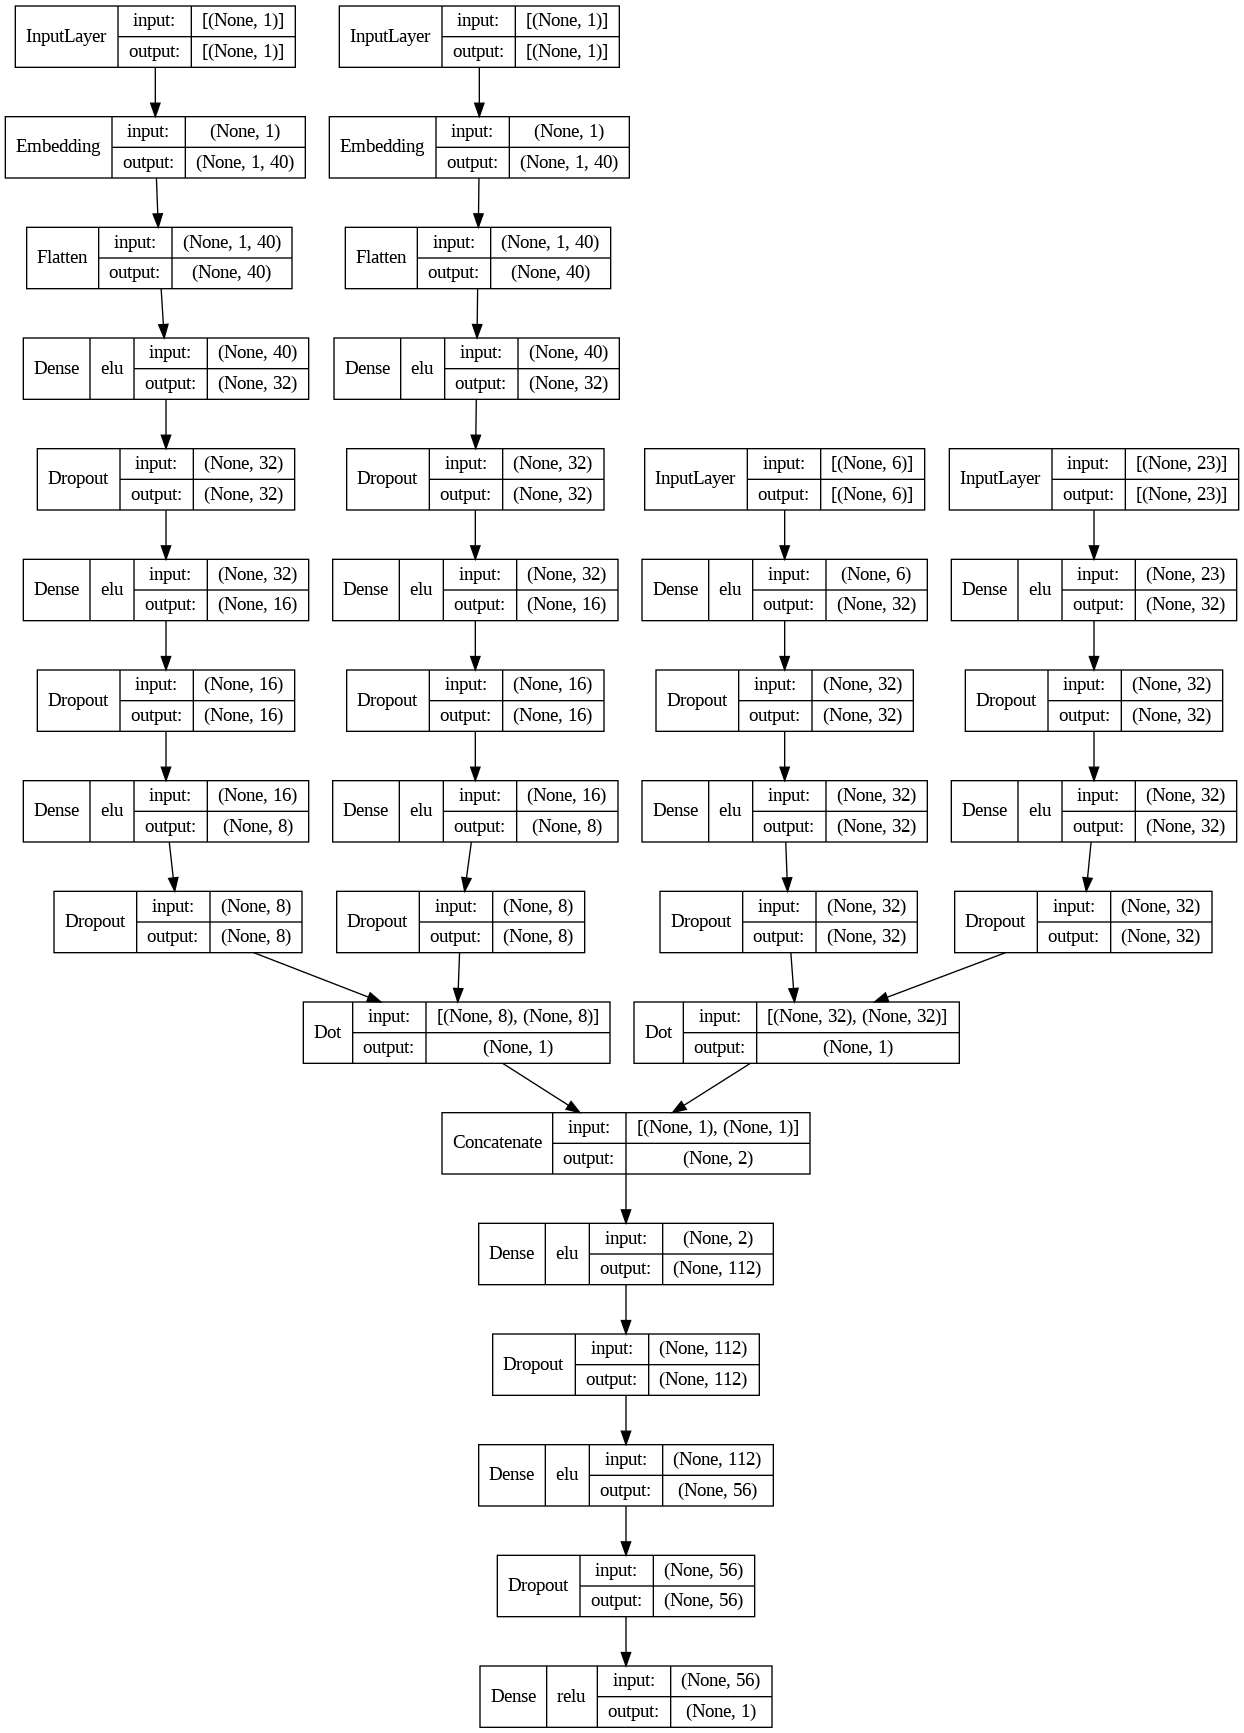

In [90]:
# And fit the same model, but with upsemple dataset
user_input = Input(shape = (1, ), dtype = 'int64')
user_embedding = Embedding(users.shape[0] + 1, n_output_neurons)(user_input)
user_vec = Flatten()(user_embedding)
for i in range(n_layers_after_embending):
    user_vec = Dense(n_neurons_after_embending // 2 ** (i), activation = 'elu')(user_vec)
    user_vec = Dropout(drop_out_prob)(user_vec)

movie_input = Input(shape = (1, ), dtype = 'int64')
movie_embedding = Embedding(movies.shape[0], n_output_neurons)(movie_input)
movie_vec = Flatten()(movie_embedding)
for i in range(n_layers_after_embending):
    movie_vec = Dense(n_neurons_after_embending // 2 ** (i), activation = 'elu')(movie_vec)
    movie_vec = Dropout(drop_out_prob)(movie_vec)

dot_embending = Dot(axes = 1)([user_vec, movie_vec])

user_feature_input = Input(shape = (len(users_featurs), ))
user_feature = Dense(32, activation = 'elu')(user_feature_input)
user_feature = Dropout(drop_out_prob)(user_feature)
user_feature = Dense(32, activation = 'elu')(user_feature)
user_feature = Dropout(drop_out_prob)(user_feature)

movies_feature_input = Input(shape = (len(ganers), ))
movies_feature = Dense(32, activation = 'elu')(movies_feature_input)
movies_feature = Dropout(drop_out_prob)(movies_feature)
movies_feature = Dense(32, activation = 'elu')(movies_feature)
movies_feature = Dropout(drop_out_prob)(movies_feature)

dot_features = Dot(axes = 1)([user_feature, movies_feature])

dot = concatenate([dot_embending, dot_features])

for i in range(n_output_layers):
    dot = Dense(n_neurons_after_output // 2 ** (i), activation = 'elu')(dot)
    dot = Dropout(drop_out_prob)(dot)

dot = Dense(1, activation = 'relu')(dot)

model = Model([user_input, movie_input, user_feature_input, movies_feature_input], dot)
model.compile(optimizer = Nadam(learning_rate = 0.001), loss = 'mse', metrics = ['mae'])

plot_model(model, show_shapes = True, show_layer_names = False, show_layer_activations = True)

In [91]:
history = model.fit([train['userId'], train['movieId'], train[users_featurs], train[ganers]], train['rating'],
                            validation_data = ([test['userId'], test['movieId'],
                                                test[users_featurs], test[ganers]], test['rating']),
                            batch_size = 64, epochs = 50, callbacks = [earlyStopping, reduceLR])

Epoch 1/50
5922/5922 [==============================] - 76s 12ms/step - loss: 0.0330 - mae: 0.1339 - val_loss: 0.0195 - val_mae: 0.0973 - lr: 0.0010
Epoch 2/50
5922/5922 [==============================] - 65s 11ms/step - loss: 0.0225 - mae: 0.1075 - val_loss: 0.0174 - val_mae: 0.0867 - lr: 0.0010
Epoch 3/50
5922/5922 [==============================] - 66s 11ms/step - loss: 0.0212 - mae: 0.1033 - val_loss: 0.0168 - val_mae: 0.0843 - lr: 0.0010
Epoch 4/50
5922/5922 [==============================] - 66s 11ms/step - loss: 0.0205 - mae: 0.1011 - val_loss: 0.0164 - val_mae: 0.0824 - lr: 0.0010
Epoch 5/50
5922/5922 [==============================] - 67s 11ms/step - loss: 0.0200 - mae: 0.0996 - val_loss: 0.0165 - val_mae: 0.0839 - lr: 0.0010
Epoch 6/50
5922/5922 [==============================] - 64s 11ms/step - loss: 0.0196 - mae: 0.0985 - val_loss: 0.0164 - val_mae: 0.0836 - lr: 0.0010
Epoch 7/50
5922/5922 [==============================] - 65s 11ms/step - loss: 0.0194 - mae: 0.0978 - val_l

MSE: 0.30317390668780725
RMSE: 0.5506123016132197
MAE: 0.33098889189055763
MSlogE: 0.02215745998351888
R^2: 0.7580990385748461


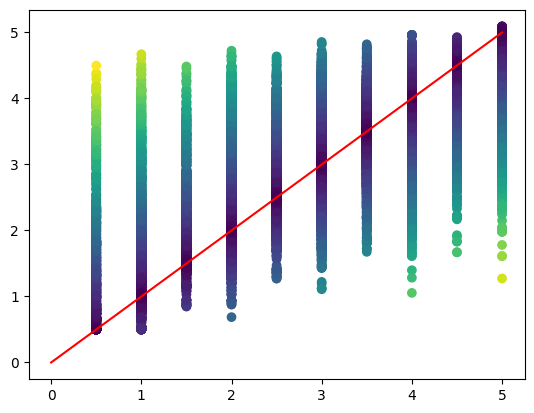

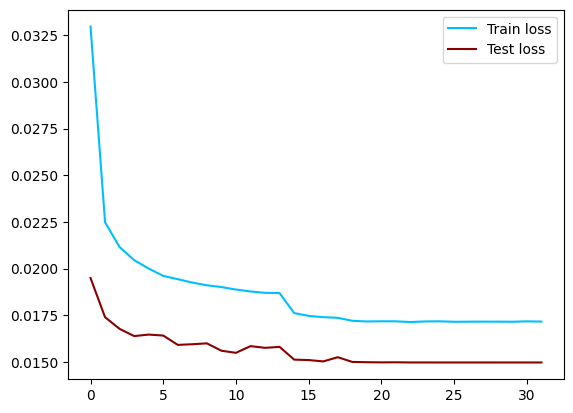

In [92]:
predicted = model.predict([test['userId'], test['movieId'], test[users_featurs], test[ganers]], verbose = False)
evaluate_model(minMaxScaler.inverse_transform(test['rating'].values.reshape(-1, 1)),
               minMaxScaler.inverse_transform(predicted[:, 0].reshape(-1, 1)),
               history)

In [93]:
# And get recomendations for my user
df_movies['movieId'] = df_movies['movieId'].apply(lambda x: movieid2idx[x])
fils_featurs = df_movies[df_movies['movieId'].isin(films)]
my_avg = np.ones(shape = len(films)) * raitings.mean()
my_med = np.ones(shape = len(films)) * np.median(raitings)
my_std = np.ones(shape = len(films)) * raitings.std()
my_1 = np.ones(shape = len(films)) * np.quantile(raitings, q = 0.25)
my_2 = np.ones(shape = len(films)) * np.quantile(raitings, q = 0.75)
my_skew = np.ones(shape = len(films)) * skew(raitings)

scaled_raitings = minMaxScaler.transform(raitings.reshape(-1, 1))

my_df = pd.DataFrame({"user_avg_rating" : my_avg,
                   "user_med_rating" : my_med,
                   "user_std_rating" : my_std,
                   "user_1quantile_rating" : my_1,
                   "user_3quantile_rating" : my_2,
                   "user_skew_rating" : my_skew})

my_df = standartScaler.transform(my_df)

my_user = np.ones(shape = len(films)) * (users.shape[0] + 1)
model.fit([my_user, films, my_df, fils_featurs[ganers]],
           scaled_raitings, epochs = 8, batch_size = 1, verbose = False)

my_avg = np.ones(shape = movies.shape[0]) * raitings.mean()
my_med = np.ones(shape = movies.shape[0]) * np.median(raitings)
my_std = np.ones(shape = movies.shape[0]) * raitings.std()
my_1 = np.ones(shape = movies.shape[0]) * np.quantile(raitings, q = 0.25)
my_2 = np.ones(shape = movies.shape[0]) * np.quantile(raitings, q = 0.75)
my_skew = np.ones(shape = movies.shape[0]) * skew(raitings)

my_df = pd.DataFrame({"user_avg_rating" : my_avg,
                   "user_med_rating" : my_med,
                   "user_std_rating" : my_std,
                   "user_1quantile_rating" : my_1,
                   "user_3quantile_rating" : my_2,
                   "user_skew_rating" : my_skew})

my_df = standartScaler.transform(my_df)

my_user = np.ones(shape = movies.shape[0]) * (users.shape[0] + 1)
my_predictions = minMaxScaler.inverse_transform(model.predict([my_user, np.array(sorted(movies)), my_df,
                                df_movies[ganers].iloc[: movies.shape[0], :]]).reshape(-1, 1))

df_movies = pd.read_csv(open("movies.csv", 'rb'))
sorted_indices = np.argsort(my_predictions.flatten())[::-1]
recommended_movies_indices = sorted_indices[:top_n]

recommended_movies = df_movies.iloc[recommended_movies_indices]
predicted_ratings = my_predictions[recommended_movies_indices]

for (idx, row), raiting in zip(recommended_movies.iterrows(), predicted_ratings):
    print(row['title'])
    print(row['genres'])
    print("raiting:", raiting, "\n")


286/286 [==============================] - 1s 2ms/step
Jakob the Liar (1999)
Drama
raiting: [5.017473] 

Damage (Fatale) (1992)
Drama
raiting: [4.996545] 

Phantom Tollbooth, The (1970)
Adventure|Animation|Children|Fantasy
raiting: [4.976511] 

Big Trouble (2002)
Comedy|Crime
raiting: [4.9739213] 

Enemy Below, The (1957)
Action|Drama|War
raiting: [4.9699] 

